# Import Library

In [1]:
import os
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.model_selection import train_test_split
import random
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Load Dataset

Pada tahap ini, dilakukan proses pemuatan (loading) dataset dari file CSV (rental_data.csv) ke dalam struktur DataFrame menggunakan pustaka pandas.

**Hasil atau Temuan Utama**:
- Dataset berhasil dimuat tanpa error.
- Isi data terlihat konsisten, tidak ditemukan anomali langsung dari 5 baris pertama (head()), menunjukkan data memiliki format yang rapi dan terstruktur.

In [2]:
df1 = pd.read_csv("rental-recommender-data/rental_data.csv")
df1.head()

,property_id,property_name,address,rent,size_sqm,layout,year_built,distance_to_station_km,description
0,1,Property_1,"Osaka, Namba",174337,83,1K,1997,1.0,Stylish loft with modern design and features.
1,2,Property_2,"Fukuoka, Tenjin",117487,95,1DK,2019,3.0,Affordable housing option with all the basics.
2,3,Property_3,"Tokyo, Shinjuku",113384,96,1LDK,1982,1.7,"A quiet and green environment, perfect for fam..."
3,4,Property_4,"Yokohama, Minato Mirai",76089,72,2DK,2007,0.9,Bright and spacious apartment in the heart of ...
4,5,Property_5,"Kyoto, Gion",179994,99,2K,2010,1.8,"A quiet and green environment, perfect for fam..."


# Data Understanding

Pada tahap ini, dilakukan pemahaman menyeluruh terhadap struktur, kualitas, dan karakteristik dasar dataset properti sewa Jepang melalui analisis statistik deskriptif dan profiling data.

- Memeriksa jumlah total baris data
- Memeriksa nilai kosong (null/missing values) di seluruh kolom
- Memeriksa baris duplikat
- Deteksi outlier secara statistik pada kolom numerik utama
- Mengidentifikasi jumlah kategori unik pada kolom layout
- Mengidentifikasi jumlah kategori unik pada kolom address (lokasi)
- Mengekstrak statistik deskriptif (min, max, mean, median, Q1, Q3, std dev) untuk kolom numerik:
    - rent (harga sewa)  
    - size_sqm (luas properti)  
    - year_built (tahun dibangun)  
    - distance_to_station_km (jarak ke stasiun)

**Hasil atau Temuan Utama**:
- 1000 total baris data
- 0 total baris null
- 0 total baris duplikat
- 0 total baris outlier
- 8 kategori unik layout: '1K', '1DK', '1LDK', '2DK', '2K', '1R', '2LDK', '3LDK'
- 10 kategori unik alamat: 'Osaka, Namba', 'Fukuoka, Tenjin', 'Tokyo, Shinjuku', 'Yokohama, Minato Mirai', 'Kyoto, Gion', 'Kobe, Harborland''Hiroshima, Peace Park', 'Sapporo, Susukino', 'Sendai, Aoba', 'Nagoya, Sakae'
- statistik deskriptif kolom numerik ('rent', 'size_sqm', 'year_built', 'distance_to_station_km'):

| Variabel                     | Min    | 25%    | Median  | Mean    | 75%     | Max     | Std Dev |
| ---------------------------- | ------ | ------ | ------- | ------- | ------- | ------- | ------- |
| **`rent` (Yen)**             | 50,120 | 87,004 | 125,720 | 125,451 | 162,713 | 199,998 | 43,243  |
| **`size_sqm` (m²)**          | 15.0   | 36.0   | 58.0    | 57.21   | 78.0    | 100.0   | 24.52   |
| **`year_built`**             | 1980   | 1990   | 2001    | 2001    | 2012    | 2023    | 12.62   |
| **`distance_to_station_km`** | 0.1    | 0.8    | 1.55    | 1.55    | 2.3     | 3.0     | 0.86    |

In [3]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   property_id             1000 non-null   int64  
 1   property_name           1000 non-null   object 
 2   address                 1000 non-null   object 
 3   rent                    1000 non-null   int64  
 4   size_sqm                1000 non-null   int64  
 5   layout                  1000 non-null   object 
 6   year_built              1000 non-null   int64  
 7   distance_to_station_km  1000 non-null   float64
 8   description             1000 non-null   object 
dtypes: float64(1), int64(4), object(4)
memory usage: 70.4+ KB


## Cek Data Null

In [4]:
df1.isnull().sum()

property_id               0
property_name             0
address                   0
rent                      0
size_sqm                  0
layout                    0
year_built                0
distance_to_station_km    0
description               0
dtype: int64

## Cek Data Duplikat

In [5]:
df1.duplicated().sum()

0

## Cek Outlier

In [6]:
numeric_cols = ['rent', 'size_sqm', 'year_built', 'distance_to_station_km']


all_outlier_indices = set()

for col in numeric_cols:
    Q1 = df1[col].quantile(0.25)
    Q3 = df1[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df1[(df1[col] < lower_bound) | (df1[col] > upper_bound)]
    all_outlier_indices.update(outliers.index)

    print(f"\nKolom: {col}")
    print(f"Jumlah outlier: {len(outliers)}")
    print(f"Lower Bound: {lower_bound:.2f}, Upper Bound: {upper_bound:.2f}")

print(f"\nTotal baris unik yang mengandung outlier: {len(all_outlier_indices)}")


Kolom: rent
Jumlah outlier: 0
Lower Bound: -26558.25, Upper Bound: 276275.75

Kolom: size_sqm
Jumlah outlier: 0
Lower Bound: -27.00, Upper Bound: 141.00

Kolom: year_built
Jumlah outlier: 0
Lower Bound: 1957.00, Upper Bound: 2045.00

Kolom: distance_to_station_km
Jumlah outlier: 0
Lower Bound: -1.45, Upper Bound: 4.55

Total baris unik yang mengandung outlier: 0


## Cek Kategori Layout

In [7]:
df1['layout'].nunique()
df1['layout'].unique()

array(['1K', '1DK', '1LDK', '2DK', '2K', '1R', '2LDK', '3LDK'],
      dtype=object)

## Cek Kategori Address

In [8]:
df1['address'].nunique()
df1['address'].unique()

array(['Osaka, Namba', 'Fukuoka, Tenjin', 'Tokyo, Shinjuku',
       'Yokohama, Minato Mirai', 'Kyoto, Gion', 'Kobe, Harborland',
       'Hiroshima, Peace Park', 'Sapporo, Susukino', 'Sendai, Aoba',
       'Nagoya, Sakae'], dtype=object)

## Statistik deskriptif

In [9]:
df1[numeric_cols].describe()

,rent,size_sqm,year_built,distance_to_station_km
count,1000.00000,1000.000000,1000.00000,1000.000000
mean,125451.49900,57.207000,2000.99600,1.545500
std,43242.83224,24.515529,12.61924,0.858042
min,50120.00000,15.000000,1980.00000,0.100000
25%,87004.50000,36.000000,1990.00000,0.800000
50%,125719.50000,58.000000,2001.00000,1.550000
75%,162713.00000,78.000000,2012.00000,2.300000
max,199998.00000,100.000000,2023.00000,3.000000


# EDA

Pada tahap ini, dilakukan analisis eksploratif terhadap data untuk memahami karakteristik, distribusi, pola, dan potensi hubungan antar variabel. EDA bertujuan memberikan gambaran awal terhadap data dan membantu mengidentifikasi tren atau anomali sebelum memasuki tahap pemodelan.

- Visualisasi distribusi data dengan histogram terhadap kolom numerik serta menampilkan statistik skewness, 
- Visualisasi Rata-Rata Harga Sewa per Lokasi
- Visualisasi Rata-Rata Harga Sewa berdasarkan Tahun Dibangun
- Visualisasi Rata-Rata Harga Sewa per Layout
- Visualisasi Jarak ke Stasiun vs. Harga Sewa
- Visualisasi Ukuran Properti vs. Harga Sewa
- Visualisasi Rata-Rata Ukuran Properti per Lokasi
- Visualisasi Distribusi Jumlah Properti per Lokasi

**Hasil atau Temuan Utama**:
- Distribusi data numerik normal - Semua variabel memiliki skewness dalam rentang -0.5 hingga 0.5
- Variasi harga berdasarkan lokasi - Kyoto dan Sapporo memiliki harga sewa tertinggi, sedangkan Sendai terendah
- Usia bangunan bukan faktor penentu - Tidak ada korelasi konsisten antara tahun pembangunan dengan harga sewa
- Layout mempengaruhi harga - Layout 1LDK paling mahal, sedangkan 2K dan 1R paling murah
- Pengaruh jarak stasiun bervariasi per kota - Kobe, Kyoto, Hiroshima menunjukkan korelasi negatif yang jelas, kota lain lemah
- Hubungan ukuran-harga tidak universal - Yokohama, Fukuoka, Kyoto menunjukkan korelasi positif yang kuat, kota lain lemah atau bahkan negatif
- Variasi ukuran properti - Kyoto memiliki properti terbesar, Fukuoka dan Sendai terkecil (~50m²)
- Sebaran inventory - Kobe memiliki properti terbanyak (~120 unit), Sendai paling sedikit

## Visualisasi dan Cek Distribusi data

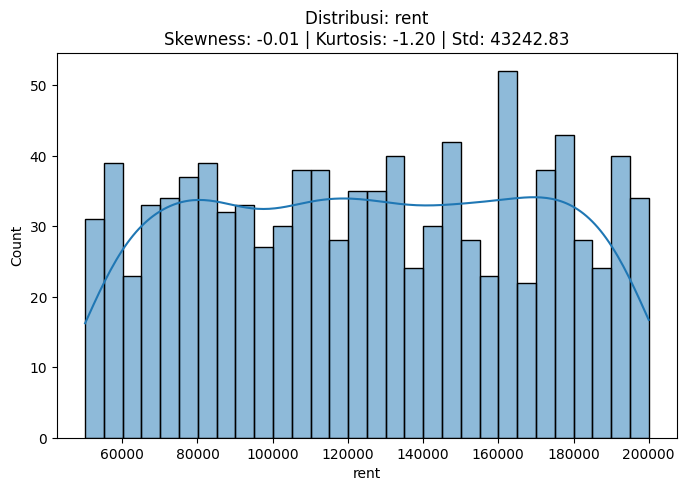

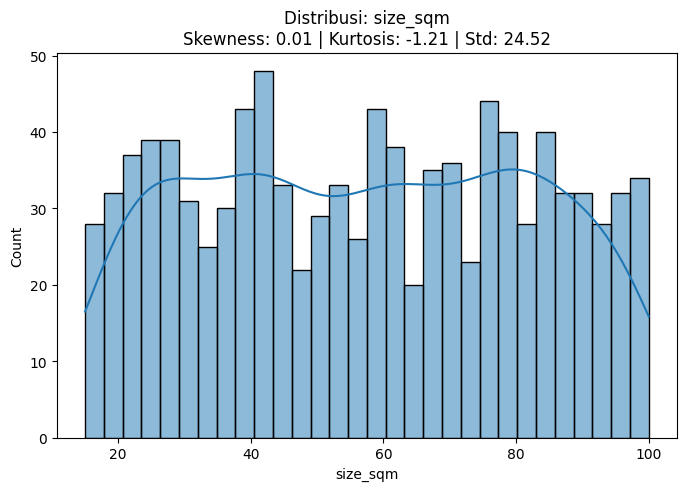

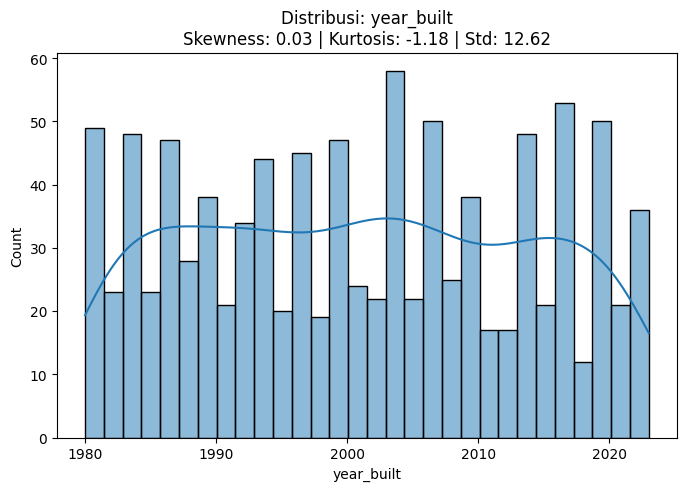

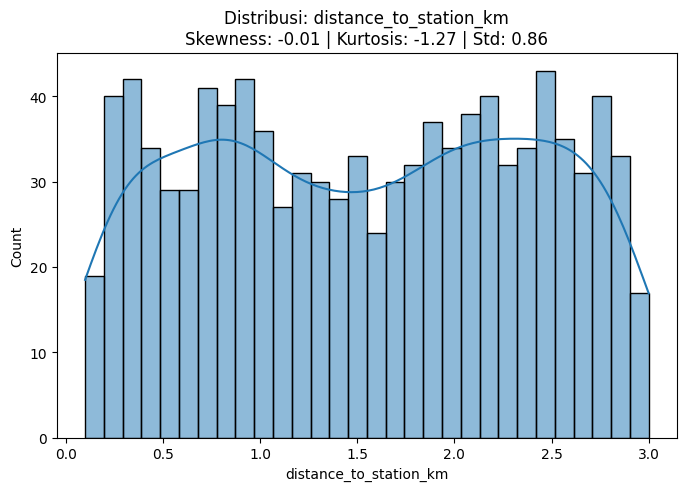

In [10]:
for col in numeric_cols:
    plt.figure(figsize=(8,5))
    sns.histplot(df1[col], bins=30, kde=True)

    mean = df1[col].mean()
    median = df1[col].median()
    std = df1[col].std()
    skewness = skew(df1[col].dropna())
    kurt = kurtosis(df1[col].dropna())

    
    plt.title(f'Distribusi: {col}\nSkewness: {skewness:.2f} | Kurtosis: {kurt:.2f} | Std: {std:.2f}')

**Hasil insight:** *Skewness semua variabel numerik masih berada pada rentang -0.5 ~ 0.5, dimana berarti semua distribusi dalam rentang normal*

## Rata-Rata Harga Sewa per Lokasi

C:\Users\ljhab\AppData\Local\Temp\ipykernel_10904\3653093550.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df1, x='city', y='rent', estimator='mean', ci=None)


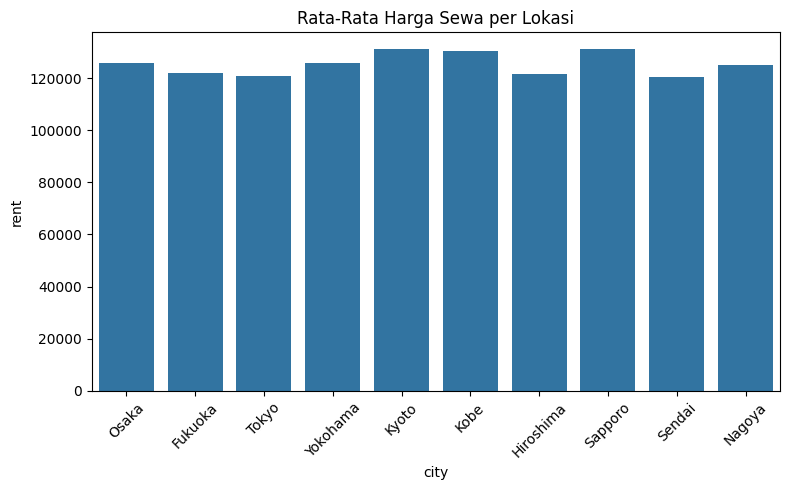

In [11]:
df1['city'] = df1['address'].str.split(',').str[0].str.strip()

plt.figure(figsize=(8,5))
sns.barplot(data=df1, x='city', y='rent', estimator='mean', ci=None)
plt.title('Rata-Rata Harga Sewa per Lokasi')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Hasil insight:** *Rata rata harga sewa di seluruh lokasi berada pad arange 120.000 ke atas. Rata-rata harga properti di Kyoto dan Saporo memiliki nilai rata-rata harga yang paling tinggi dibandingkan yang lainnya sedangkan Sendai memiliki nilai rata-rata harga properti yang lebih rendah dibandingkan lokasi lain.*

## Rata-Rata Harga Sewa berdasarkan Tahun Dibangun

C:\Users\ljhab\AppData\Local\Temp\ipykernel_10904\1695483439.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df1, x='year_built', y='rent', estimator='mean', ci=None)


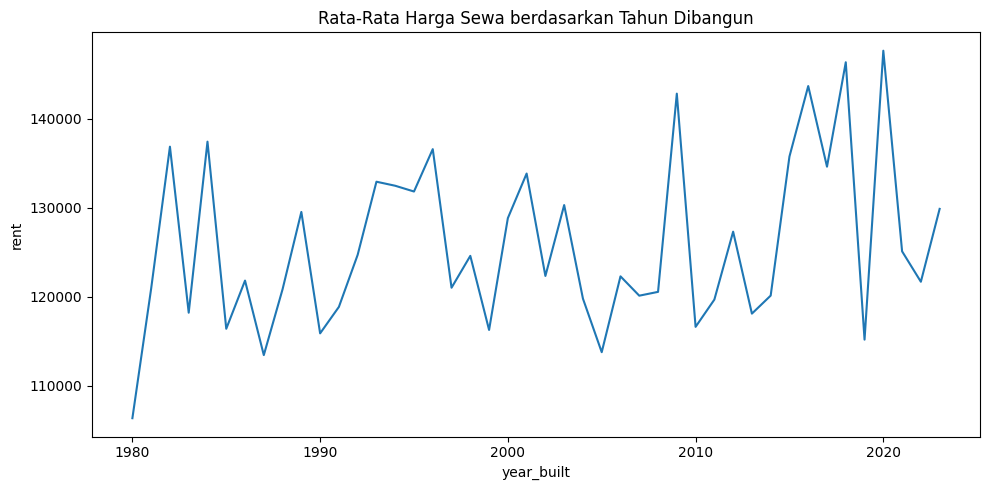

In [12]:
plt.figure(figsize=(10,5))
sns.lineplot(data=df1, x='year_built', y='rent', estimator='mean', ci=None)
plt.title('Rata-Rata Harga Sewa berdasarkan Tahun Dibangun')
plt.tight_layout()
plt.show()

**Hasil insight:** *Tidak ada tren yang konsisten naik/turun antara tahun pembangunan dengan rata-rata harga sewa, tren nya cenderung fluktuatif yang menunjukkan bahwa usia bangunan bukan faktor utama yang menentukan harga sewa.*

## Rata-Rata Harga Sewa per Layout

C:\Users\ljhab\AppData\Local\Temp\ipykernel_10904\124613051.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df1, x='layout', y='rent', estimator='mean', ci=None)


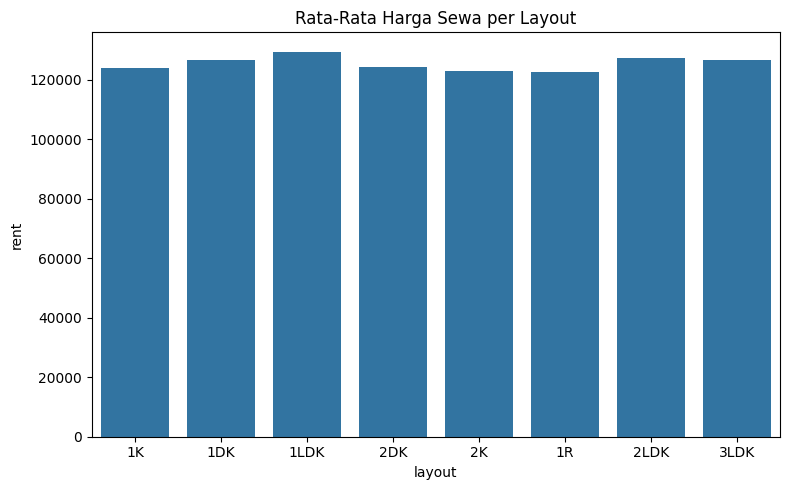

In [13]:
plt.figure(figsize=(8,5))
sns.barplot(data=df1, x='layout', y='rent', estimator='mean', ci=None)
plt.title('Rata-Rata Harga Sewa per Layout')
plt.tight_layout()
plt.show()

**Hasil insight:** *Layout 1LDK memiliki rata-rata harga sewa yang lebih tinggi sedangkan layout 2K dan 1R memiliki rata-rata harga sewa paling kecil*

## Jarak ke Stasiun vs. Harga Sewa

<Figure size 1200x800 with 0 Axes>

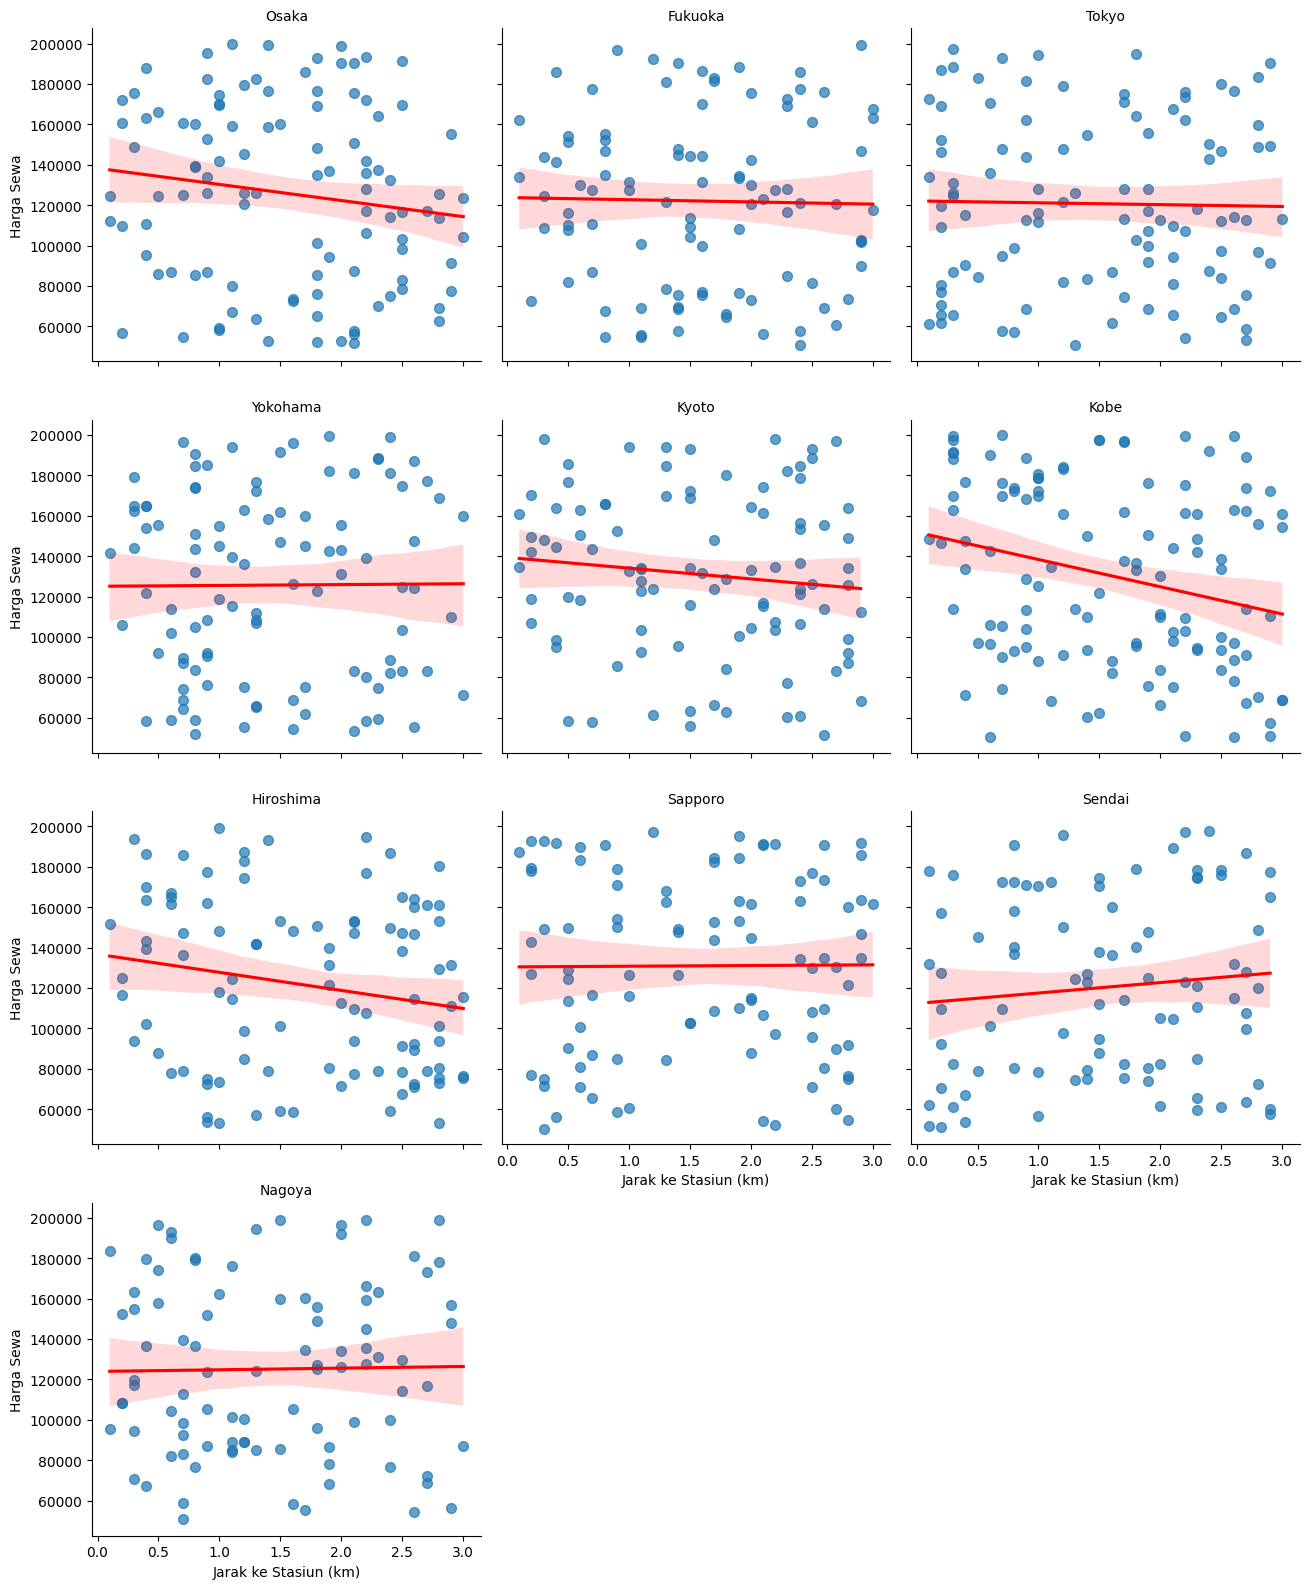

In [14]:
# Menggunakan FacetGrid untuk pemisahan yang lebih rapi
plt.figure(figsize=(12, 8))
g = sns.FacetGrid(df1, col='city', col_wrap=3, height=4, aspect=1.1)
g.map(sns.regplot, 'distance_to_station_km', 'rent', scatter_kws={'alpha':0.7, 's':50}, line_kws={'color':'red'})
g.set_axis_labels('Jarak ke Stasiun (km)', 'Harga Sewa')
g.set_titles('{col_name}')
plt.show()

**Hasil insight:** *Kota seperti Kobe, Kyoto, Hiroshima menunjukkan tren yang cukup jelas: semakin jauh dari stasiun, harga sewa menurun. Sementar aitu, lokasi lain korelasinya sangat lemah atau bahkan hampir datar*

## Ukuran Properti vs. Harga Sewa

<Figure size 1200x800 with 0 Axes>

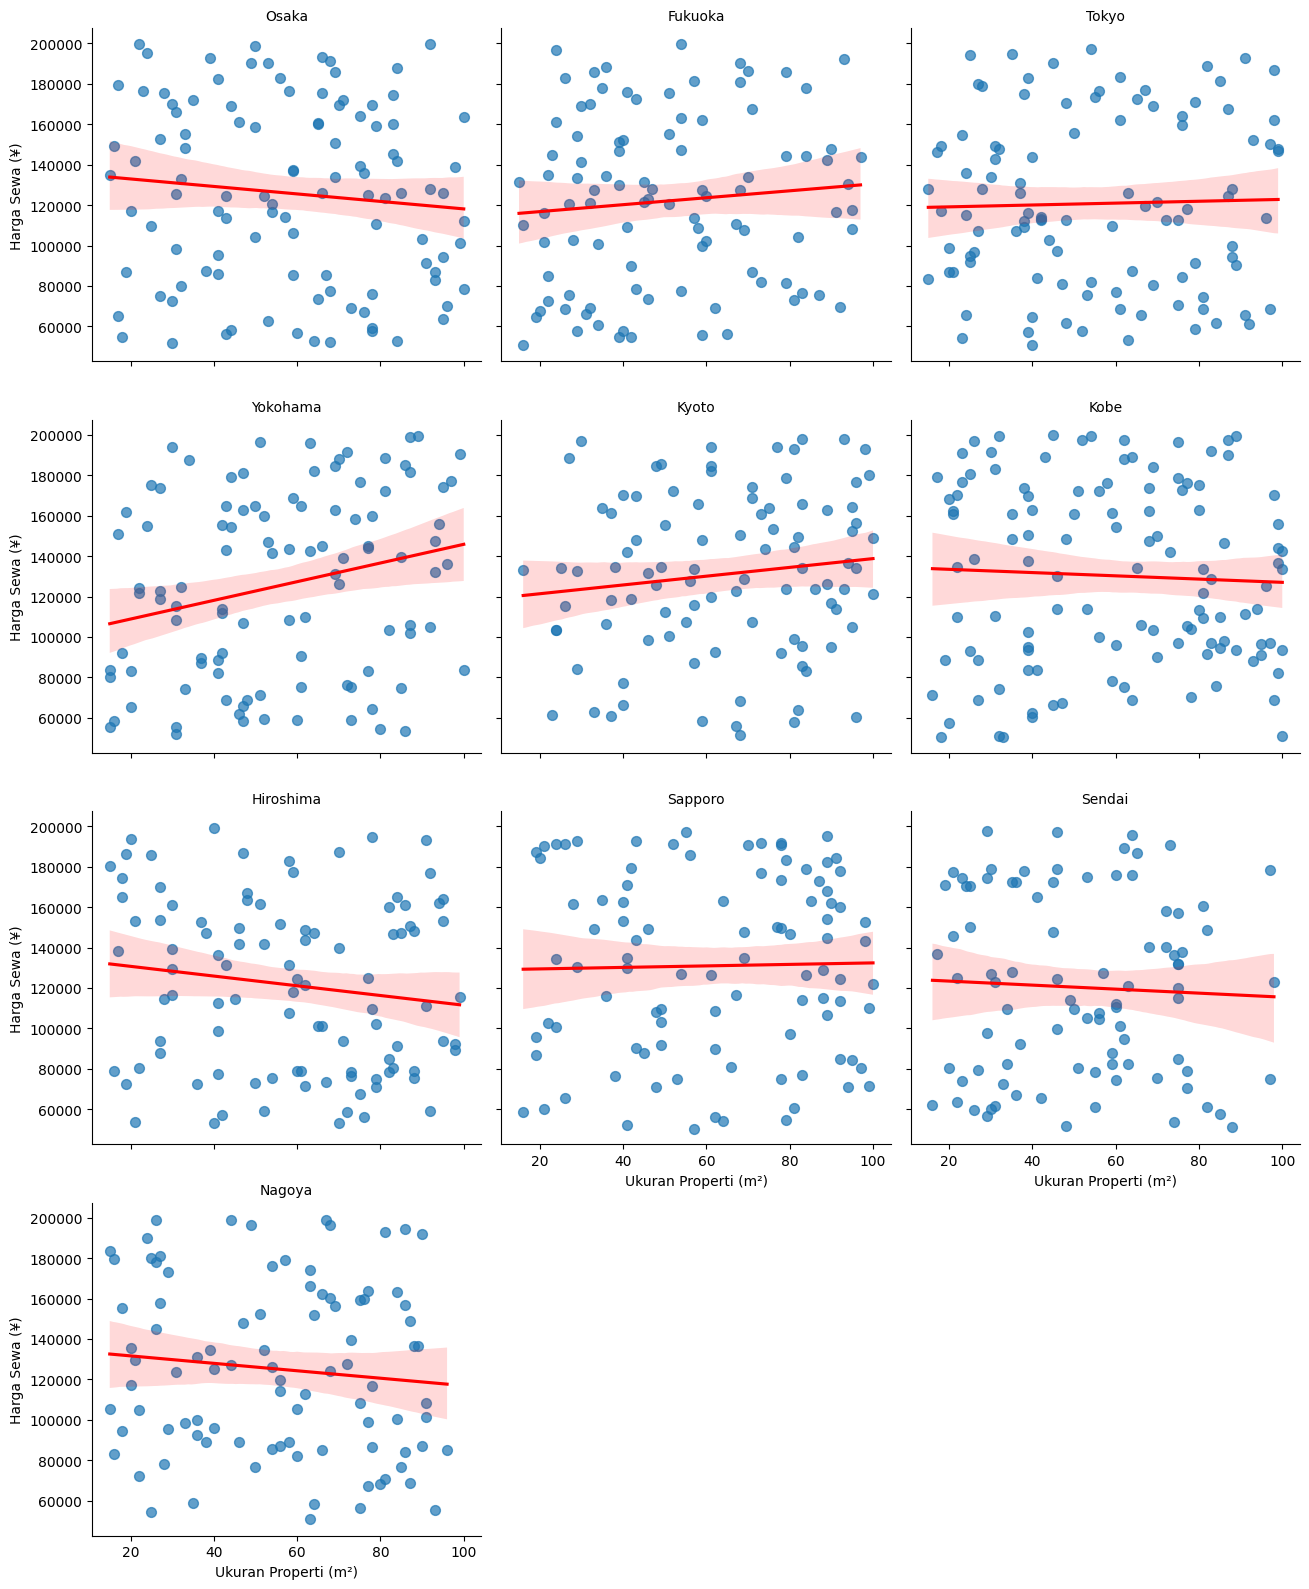

In [15]:
# FacetGrid untuk Ukuran Properti vs. Harga Sewa per Lokasi
plt.figure(figsize=(12, 8))
# FacetGrid dengan regplot untuk trend line otomatis
g = sns.FacetGrid(df1, col='city', col_wrap=3, height=4, aspect=1.1)
g.map(sns.regplot, 'size_sqm', 'rent', scatter_kws={'alpha':0.7, 's':50}, line_kws={'color':'red'})
g.set_axis_labels('Ukuran Properti (m²)', 'Harga Sewa (¥)')
g.set_titles('{col_name}')
plt.tight_layout()
plt.show()

**Hasil insight:** *Kota seperti Yokohama, Fukuoka, Kyoto menunjukkan tren naik yang jelas, semakin besar ukuran properti, semakin mahal harga sewanya. Sementara lokasi lain, hubungan antara ukuran dan harga sewa tidak terlalu kuat atau bahkan cenderung negatif yang menunjukkan bahwa di beberapa kota, harga sewa tidak sepenuhnya proporsional terhadap ukuran*

## Rata-Rata Ukuran Properti per Lokasi

C:\Users\ljhab\AppData\Local\Temp\ipykernel_10904\999149608.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df1, x='city', y='size_sqm', estimator='mean', ci=None)


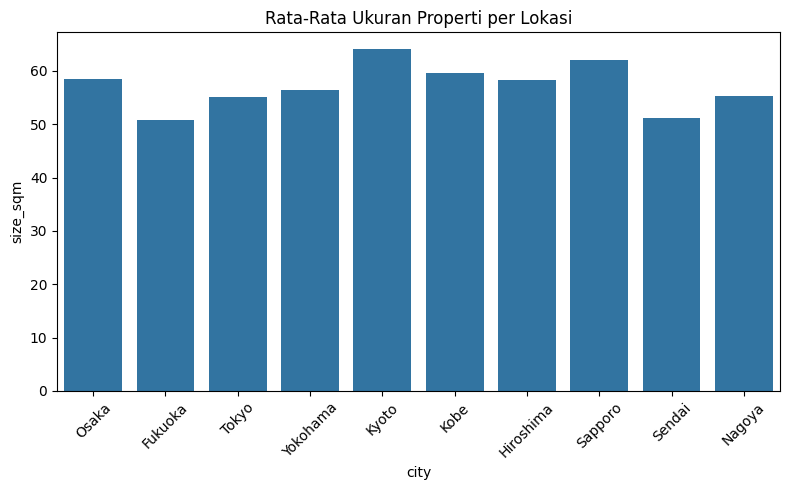

In [16]:
plt.figure(figsize=(8,5))
sns.barplot(data=df1, x='city', y='size_sqm', estimator='mean', ci=None)
plt.title('Rata-Rata Ukuran Properti per Lokasi')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Hasil insight:** *Kyoto memiliki rata rata ukuran properti paling besar dibandingkan lokasi lain, dimana Fukuoka dan Sendai memiliki rata rata ukuran paling kecil diantara semua lokasi yaitu sebsar 50 meter persegi*

## Distribusi Jumlah Properti per Lokasi

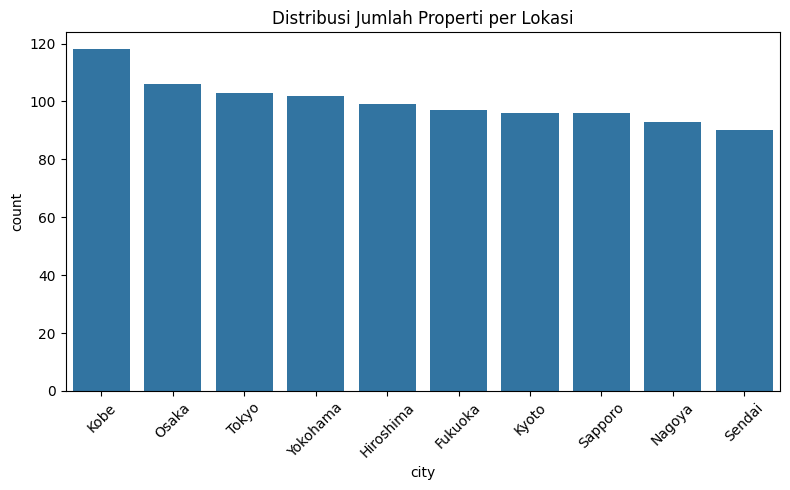

In [17]:
plt.figure(figsize=(8,5))
sns.countplot(data=df1, x='city', order=df1['city'].value_counts().index)
plt.title('Distribusi Jumlah Properti per Lokasi')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Hasil insight:** *Kobe memiliki jumlah properti terbanyak dari semua kota hampir mendekati 120 jumlah properti sedangkan Sendai memiliki jumlah properti paling sedikit*

# Data Preprocessing

Pada tahap ini, dilakukan persiapan data mentah agar bersih, terstruktur, dan siap digunakan oleh algoritma sistem rekomendasi. Tahapannya meliputi:

- Text Preprocessing untuk Kolom description. Membuat teks lebih seragam untuk diproses oleh model teks TF-IDF nantinya. Diantaranya dengan:
    - Mengubah semua huruf menjadi huruf kecil (lowercase)
    - Menghapus karakter khusus (seperti tanda baca, simbol)
    - Normalisasi spasi (menghapus spasi ganda)

- Normalisasi Fitur Numerik. Menstandarkan nilai fitur numerik ke rentang [0,1] untuk mencegah fitur dengan skala besar (seperti rent) mendominasi model.
- Encoding Kategorik (One-Hot Encoding). Mengubah fitur kategorikal (seperti layout dan address) menjadi representasi numerik.
- TF-IDF pada kolom description. Mengekstrak fitur tekstual dari kolom description_clean (kolom hasil output dari Text Preprocessing untuk Kolom description) dengan TF-IDF (Term Frequency-Inverse Document Frequency), yaitu menghitung pentingnya kata/kalimat dalam dokumen relatif terhadap semua dokumen.
*Setelah mendapatkan representasi TF-IDF dalam bentuk matriks, dilakukan reduksi dimensi menggunakan PCA (Principal Component Analysis) untuk merangkum informasi penting ke dalam 50 komponen utama. Hal ini membantu mengurangi kompleksitas fitur teks, mempercepat proses, dan mengurangi overfitting tanpa menghilangkan informasi penting.*


- Menggabungkan Semua Fitur. Membentuk satu matriks fitur gabungan yang berisi seluruh informasi penting: fitur numerik yang sudah di normalisasi, fitur kategorik yang sudah di encoding, dan fitur teks yang telah diekstrak dengan TF-IDF sebagai input akhir untuk proses rekomendasi.

**Hasil atau Temuan Utama:**
- Proses preprocessing berhasil mengurangi noise pada data dan menghasilkan representasi fitur yang lebih konsisten dan terstruktur.
- Kombinasi TF-IDF dan PCA memungkinkan sistem memahami konteks penting dari deskripsi properti sambil menjaga efisiensi dan performa model melalui reduksi dimensi.
- Normalisasi dan encoding berhasil menyatukan fitur numerik dan kategorikal ke dalam satu skala yang setara, yang penting untuk menghindari bias fitur tertentu dalam sistem rekomendasi.
- Matriks fitur akhir yang dihasilkan siap digunakan dalam berbagai pendekatan sistem rekomendasi berbasis konten (content-based filtering)

## Text Preprocessing untuk Description

In [18]:
df = df1.copy()

# Text cleaning
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Hapus karakter khusus
    text = re.sub(r'\s+', ' ', text)  # Normalize whitespace
    return text.strip()

df['description_clean'] = df['description'].apply(clean_text)

## Normalisasi Numerik

In [19]:
# Pilih fitur numerik
scaler = MinMaxScaler()
numeric_scaled = scaler.fit_transform(df[numeric_cols])
numeric_scaled_df = pd.DataFrame(numeric_scaled, columns=numeric_cols, index=df.index)

## Encoding Kategorik

In [20]:
# One-hot encoding untuk layout dan address
df_encoded = pd.get_dummies(df, columns=['layout', 'address'], prefix=['layout', 'addr'])

## TF-IDF untuk Description

In [21]:
# Ekstrak fitur dari description
tfidf = TfidfVectorizer(max_features=100, stop_words='english', ngram_range=(1,2))
tfidf_matrix = tfidf.fit_transform(df['description_clean'])

# TF-IDF -> array
tfidf_array = tfidf_matrix.toarray()

# PCA
pca = PCA(n_components=50, random_state=42)
tfidf_pca = pca.fit_transform(tfidf_array)

tfidf_df = pd.DataFrame(tfidf_pca, columns=[f'pca_{i+1}' for i in range(50)])

In [22]:
tfidf_df.head()

,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,...,pca_41,pca_42,pca_43,pca_44,pca_45,pca_46,pca_47,pca_48,pca_49,pca_50
0,-0.023294,3.303609e-17,0.234534,-0.318958,0.789438,-0.320033,-0.100994,-0.110129,-0.010707,-1.110223e-16,...,-7.632783e-17,3.295975e-17,-3.816392e-17,3.469447e-18,0.000000e+00,-3.295975e-17,-2.949030e-17,-2.168404e-17,5.724587e-17,3.295975e-17
1,-0.438331,7.071068e-01,-0.422497,0.062023,-0.028896,-0.049739,-0.036478,-0.046992,-0.005169,5.273559e-16,...,4.163336e-17,-1.387779e-17,-2.428613e-17,2.081668e-17,-2.775558e-17,1.170938e-17,4.163336e-17,1.821460e-17,-7.806256e-17,5.377643e-17
2,0.732212,-4.987255e-15,-0.416071,0.078326,-0.039158,-0.080555,-0.381944,0.048391,-0.000410,2.220446e-16,...,-1.040834e-17,2.428613e-17,-1.734723e-17,2.775558e-17,-3.469447e-18,-4.336809e-19,5.898060e-17,1.170938e-17,1.908196e-17,-1.127570e-17
3,-0.028453,-4.264973e-16,0.357501,0.410795,-0.097541,-0.099282,-0.035543,-0.005596,0.764947,3.053113e-16,...,4.857226e-17,5.377643e-17,-6.938894e-18,-5.898060e-17,-3.469447e-18,-1.127570e-17,5.984796e-17,-2.515349e-17,-3.469447e-17,3.469447e-18
4,0.732212,-4.987255e-15,-0.416071,0.078326,-0.039158,-0.080555,-0.381944,0.048391,-0.000410,2.220446e-16,...,-1.040834e-17,2.428613e-17,-1.734723e-17,2.775558e-17,-3.469447e-18,-4.336809e-19,5.898060e-17,1.170938e-17,1.908196e-17,-1.127570e-17


## Gabungkan Semua Fitur

In [23]:
# Combine all features
feature_matrix = pd.concat([
    numeric_scaled_df,  # Numerical features
    df_encoded[[col for col in df_encoded.columns if col.startswith(('layout_', 'addr_'))]],  # Categorical
    tfidf_df  # Text features
], axis=1)

# Preparation pre-modelling

Pada tahap ini, dilakukan persiapan atriks dan struktur data yang akan digunakan untuk mencari item-item yang mirip berdasarkan fitur-fitur yang telah diproses.
- Cosine Similarity : Mengukur kesamaan arah (bukan jarak) antar vektor fitur
- K-Nearest Neighbors (KNN) : Mencari K properti paling dekat (mirip) menggunakan jarak Euclidean

**Hasil atau Temuan Utama**:
Matriks similarity dan struktur neighbors yang telah dibangun siap digunakan pada tahap inferensi dan pengujian sistem rekomendasi.

### Cosine Similarity

In [24]:
# Hitung similarity matrix
similarity_matrix = cosine_similarity(feature_matrix)

### KNN

In [25]:
knn_model = NearestNeighbors(metric='euclidean', n_neighbors=25)
knn_model.fit(feature_matrix)

distances, indices = knn_model.kneighbors(feature_matrix)

# Data Modelling (Content Based Filtering - Cosine Similarity & KNN)

Pada tahapan ini dilakukan implementasi sistem rekomendasi berbasis konten (content-based filtering) menggunakan dua metode perhitungan similarity yang berbeda untuk memberikan rekomendasi properti yang relevan berdasarkan karakteristik properti yang dipilih.

- fungsi get_recommendations() - Fungsi utama untuk menghasilkan rekomendasi properti berdasarkan similarity score dengan dua metode berbeda (cosine similarity dan KNN)
- fungsi explain_recommendation() - Fungsi untuk memberikan penjelasan detail mengapa suatu properti direkomendasikan, termasuk perbandingan fitur-fitur numerik dan kategorikal
- Pengujian model dengan properti sampel - Melakukan testing menggunakan "Property_2" sebagai properti referensi untuk menghasilkan 10 rekomendasi teratas

**Hasil atau Temuan Utama**:
- Cosine Similarity

| No | Property Name | Similarity Score | Address               | Rent    | Year Built | Distance to Station (km) | Layout |
| -- | ------------- | ---------------- | --------------------- | ------- | ---------- | ------------------------ | ------ |
| 1  | Property\_21  | 0.808            | Tokyo, Shinjuku       | 91,243  | 2012       | 2.9                      | 1DK    |
| 2  | Property\_261 | 0.803            | Hiroshima, Peace Park | 91,255  | 2010       | 2.5                      | 1DK    |
| 3  | Property\_57  | 0.776            | Fukuoka, Tenjin       | 69,027  | 2007       | 2.6                      | 2K     |
| 4  | Property\_614 | 0.776            | Fukuoka, Tenjin       | 147,939 | 2009       | 1.4                      | 2K     |
| 5  | Property\_16  | 0.774            | Nagoya, Sakae         | 127,484 | 1999       | 2.2                      | 1DK    |
| 6  | Property\_735 | 0.767            | Fukuoka, Tenjin       | 192,232 | 2017       | 1.2                      | 1DK    |
| 7  | Property\_488 | 0.766            | Fukuoka, Tenjin       | 113,756 | 2022       | 1.5                      | 2K     |
| 8  | Property\_545 | 0.762            | Fukuoka, Tenjin       | 120,482 | 2007       | 2.0                      | 1DK    |
| 9  | Property\_459 | 0.762            | Fukuoka, Tenjin       | 73,702  | 2008       | 2.8                      | 2DK    |
| 10 | Property\_288 | 0.754            | Fukuoka, Tenjin       | 172,400 | 2009       | 2.3                      | 1DK    |

- KNN (distance di convert ke similarity)

| No | Property Name | Similarity Score | Address               | Rent    | Year Built | Distance to Station (km) | Layout |
| -- | ------------- | ---------------- | --------------------- | ------- | ---------- | ------------------------ | ------ |
| 1  | Property\_21  | 0.409            | Tokyo, Shinjuku       | 91,243  | 2012       | 2.9                      | 1DK    |
| 2  | Property\_261 | 0.407            | Hiroshima, Peace Park | 91,255  | 2010       | 2.5                      | 1DK    |
| 3  | Property\_57  | 0.395            | Fukuoka, Tenjin       | 69,027  | 2007       | 2.6                      | 2K     |
| 4  | Property\_16  | 0.394            | Nagoya, Sakae         | 127,484 | 1999       | 2.2                      | 1DK    |
| 5  | Property\_614 | 0.392            | Fukuoka, Tenjin       | 147,939 | 2009       | 1.4                      | 2K     |
| 6  | Property\_545 | 0.389            | Fukuoka, Tenjin       | 120,482 | 2007       | 2.0                      | 1DK    |
| 7  | Property\_488 | 0.389            | Fukuoka, Tenjin       | 113,756 | 2022       | 1.5                      | 2K     |
| 8  | Property\_459 | 0.388            | Fukuoka, Tenjin       | 73,702  | 2008       | 2.8                      | 2DK    |
| 9  | Property\_288 | 0.382            | Fukuoka, Tenjin       | 172,400 | 2009       | 2.3                      | 1DK    |
| 10 | Property\_735 | 0.381            | Fukuoka, Tenjin       | 192,232 | 2017       | 1.2                      | 1DK    |

- Fungsi explain_recommendation() mampu menyajikan alasan berbasis fitur mengapa properti direkomendasikan. contoh:
Property_21 untuk Property_2
Skor Kemiripan: 0.808 (tinggi)

| Fitur                     | Property\_2     | Property\_21    | Perbedaan | Catatan             |
| ------------------------- | --------------- | --------------- | --------- | ------------------- |
| **Rent (¥)**              | 117,487         | 91,243          | ↓ 22.3%   | Lebih murah         |
| **Ukuran (m²)**           | 95              | 79              | ↓ 16.8%   | Sedikit lebih kecil |
| **Tahun Dibangun**        | 2019            | 2012            | ↓ 0.3%    | Hampir sama         |
| **Jarak ke Stasiun (km)** | 3.0             | 2.9             | ↓ 3.3%    | Sangat mirip        |
| **Layout**                | 1DK             | 1DK             | ✅ Sama    |                     |
| **Lokasi**                | Fukuoka, Tenjin | Tokyo, Shinjuku | ❌ Berbeda |                     |

In [26]:
def get_recommendations(property_name, similarity_data, df, top_n=5, method='cosine'):
    if property_name not in df['property_name'].values:
        available = df['property_name'].tolist()
        return f"Property '{property_name}' not found! Available properties: {available}"
    
    property_idx = df[df['property_name'] == property_name].index[0]
    
    if method == 'cosine':
        similarity_matrix = similarity_data
        sim_scores = list(enumerate(similarity_matrix[property_idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:top_n+1]  # exclude itself
        property_indices = [i[0] for i in sim_scores]
        similarity_scores = [i[1] for i in sim_scores]
    
    elif method == 'knn':
        distances, indices = similarity_data
        # Exclude the first one (which is the property itself)
        property_indices = indices[property_idx][1:top_n+1]
        similarity_scores = 1 / (1 + distances[property_idx][1:top_n+1])  # Convert distance to similarity

    else:
        return "Unknown method. Use 'cosine' or 'knn'."
    
    recommendations = df.iloc[property_indices][[
        'property_name', 'address', 'rent', 'size_sqm', 'layout', 'year_built', 'distance_to_station_km', 'description'
    ]].copy()
    recommendations['similarity_score'] = similarity_scores
    
    return recommendations


## Recommendation

In [27]:
def explain_recommendation(property_name, recommended_property, similarity_data, df, method='cosine'):
    """
    Explain why a property was recommended (supports both cosine similarity and KNN)
    """
    print(f"🔍 RECOMMENDATION EXPLANATION")
    print("="*60)
    print(f"Why '{recommended_property}' is recommended for '{property_name}'")
    print("-"*60)

    # Get property details  
    original_prop = df[df['property_name'] == property_name].iloc[0]
    recommended_prop = df[df['property_name'] == recommended_property].iloc[0]

    # Get similarity score
    orig_idx = df[df['property_name'] == property_name].index[0]
    rec_idx = df[df['property_name'] == recommended_property].index[0]

    if method == 'cosine':
        similarity_score = similarity_data[orig_idx][rec_idx]
    elif method == 'knn':
        distances, indices = similarity_data
        # Find the index of the recommended property in the KNN list
        if rec_idx in indices[orig_idx]:
            pos = list(indices[orig_idx]).index(rec_idx)
            similarity_score = 1 / (1 + distances[orig_idx][pos])  # Convert distance to similarity
        else:
            similarity_score = 0  # Not in the neighborhood
    else:
        raise ValueError("Method must be 'cosine' or 'knn'")

    print(f"Overall Similarity Score: {similarity_score:.3f}\n")

    # Feature-by-feature comparison
    print("📊 FEATURE COMPARISON:")
    print("-"*30)

    # Numeric features
    numeric_features = ['rent', 'size_sqm', 'year_built', 'distance_to_station_km']
    for feature in numeric_features:
        orig_val = original_prop[feature]
        rec_val = recommended_prop[feature]
        diff_pct = abs(orig_val - rec_val) / orig_val * 100 if orig_val else 0
        print(f"{feature.upper()}:")
        print(f"  Original: {orig_val:,}")
        print(f"  Recommended: {rec_val:,}")
        print(f"  Difference: {diff_pct:.1f}%\n")

    # Categorical features
    categorical_features = ['layout', 'address']
    for feature in categorical_features:
        orig_val = original_prop[feature]
        rec_val = recommended_prop[feature]
        match = "✅ MATCH" if orig_val == rec_val else "❌ DIFFERENT"
        print(f"{feature.upper()}:")
        print(f"  Original: {orig_val}")
        print(f"  Recommended: {rec_val}")
        print(f"  Status: {match}\n")

    # Description comparison (short preview)
    print("📝 DESCRIPTION ANALYSIS:")
    print(f"Original: {original_prop['description'][:100]}...")
    print(f"Recommended: {recommended_prop['description'][:100]}...")


In [28]:
# Pilih properti untuk dianalisis
property_name = "Property_2"  # Ganti dengan nama properti yang ada
recs_cosine = get_recommendations(property_name, similarity_matrix, df, top_n=10, method='cosine')

# Jelaskan mengapa properti direkomendasikan
if isinstance(recs_cosine, pd.DataFrame) and len(recs_cosine) > 0:
    print("🔍 Top Recommendations:")
    print(recs_cosine[['property_name', 'similarity_score', 'address', 'rent', 'year_built', 'distance_to_station_km', 'layout']])

    recommended_property = recs_cosine.iloc[0]['property_name']
    explain_recommendation(property_name, recommended_property, similarity_matrix, df, method='cosine')

🔍 Top Recommendations:
    property_name  similarity_score                address    rent  \
20    Property_21          0.808279        Tokyo, Shinjuku   91243   
260  Property_261          0.803147  Hiroshima, Peace Park   91255   
56    Property_57          0.775854        Fukuoka, Tenjin   69027   
613  Property_614          0.775713        Fukuoka, Tenjin  147939   
15    Property_16          0.773822          Nagoya, Sakae  127484   
734  Property_735          0.766880        Fukuoka, Tenjin  192232   
487  Property_488          0.765688        Fukuoka, Tenjin  113756   
544  Property_545          0.762221        Fukuoka, Tenjin  120482   
458  Property_459          0.762198        Fukuoka, Tenjin   73702   
287  Property_288          0.754301        Fukuoka, Tenjin  172400   

     year_built  distance_to_station_km layout  
20         2012                     2.9    1DK  
260        2010                     2.5    1DK  
56         2007                     2.6     2K  
613       

In [29]:
recs_knn = get_recommendations(property_name, (distances, indices), df, top_n=10, method='knn')

# Jelaskan mengapa properti direkomendasikan
if isinstance(recs_knn, pd.DataFrame) and len(recs_knn) > 0:
    print("🔍 Top Recommendations:")
    print(recs_knn[['property_name', 'similarity_score', 'address', 'rent', 'year_built', 'distance_to_station_km', 'layout']])

    recommended_property = recs_knn.iloc[0]['property_name']
    explain_recommendation(property_name, recommended_property, (distances, indices), df, method='knn')

🔍 Top Recommendations:
    property_name  similarity_score                address    rent  \
20    Property_21          0.408665        Tokyo, Shinjuku   91243   
260  Property_261          0.407110  Hiroshima, Peace Park   91255   
56    Property_57          0.394683        Fukuoka, Tenjin   69027   
15    Property_16          0.393776          Nagoya, Sakae  127484   
613  Property_614          0.392121        Fukuoka, Tenjin  147939   
544  Property_545          0.389093        Fukuoka, Tenjin  120482   
487  Property_488          0.388721        Fukuoka, Tenjin  113756   
458  Property_459          0.388004        Fukuoka, Tenjin   73702   
287  Property_288          0.381840        Fukuoka, Tenjin  172400   
734  Property_735          0.381129        Fukuoka, Tenjin  192232   

     year_built  distance_to_station_km layout  
20         2012                     2.9    1DK  
260        2010                     2.5    1DK  
56         2007                     2.6     2K  
15        

# Model Evaluation

Pada tahapan ini dilakukan evaluasi menyeluruh terhadap performa sistem rekomendasi berbasis konten (content-based filtering) menggunakan berbagai metrik untuk mengukur kualitas, keragaman, dan akurasi rekomendasi yang dihasilkan oleh dua metode: Cosine Similarity dan KNN (Euclidean Distance).

- fungsi calculate_diversity_metrics() - Mengukur tingkat keragaman dan cakupan katalog dari sistem rekomendasi, termasuk catalog coverage, layout diversity, dan address diversity
- fungsi create_evaluation_data() - Mensimulasikan data interaksi pengguna dengan properti untuk keperluan evaluasi, menciptakan 200 pengguna virtual dengan 8 interaksi rata-rata per pengguna
- Implementasi fungsi evaluasi metrik utama:
```
    precision_at_k() - Mengukur relevansi rekomendasi dalam top-K
    recall_at_k() - Mengukur kemampuan sistem menemukan semua item relevan
    f1_at_k() - Harmonic mean dari precision dan recall
    ndcg_at_k() - Normalized Discounted Cumulative Gain untuk mengukur ranking quality
    hit_rate_at_k() - Mengukur apakah ada minimal satu item relevan dalam top-K
```
- fungsi get_recommendations_for_evaluation() - Menghasilkan rekomendasi berdasarkan property index untuk keperluan evaluasi sistematis
- fungsi evaluate_content_based_system() - Menjalankan evaluasi menyeluruh terhadap sistem rekomendasi dengan berbagai nilai K (5, 10, 15, 20)
- fungsi plot_evaluation_results() dan print_evaluation_summary()** - Visualisasi dan pelaporan hasil evaluasi

**Hasil atau Temuan Utama**:
1. Coverage & Diversity

| Model             | Catalog Coverage | Layout Diversity | Address Diversity |
| ----------------- | ---------------- | ---------------- | ----------------- |
| Cosine Similarity | 98.2%            | 39.9%            | 45.5%             |
| KNN               | 99.1%            | 39.6%            | 45.4%             |

2. Top-K Recommendation Performance
- Cosine Similarity

| Top-K | Precision | Recall | F1-Score | NDCG   | Hit Rate |
| ----- | --------- | ------ | -------- | ------ | -------- |
| 5     | 0.0040    | 0.0067 | 0.0049   | 0.0049 | 0.0200   |
| 10    | 0.0035    | 0.0121 | 0.0053   | 0.0073 | 0.0350   |
| 15    | 0.0033    | 0.0175 | 0.0055   | 0.0093 | 0.0500   |
| 20    | 0.0033    | 0.0242 | 0.0057   | 0.0113 | 0.0650   |

- KNN (Euclidean Distance)

| Top-K | Precision | Recall | F1-Score | NDCG   | Hit Rate |
| ----- | --------- | ------ | -------- | ------ | -------- |
| 5     | 0.0020    | 0.0025 | 0.0022   | 0.0028 | 0.0100   |
| 10    | 0.0020    | 0.0067 | 0.0030   | 0.0045 | 0.0200   |
| 15    | 0.0027    | 0.0146 | 0.0045   | 0.0073 | 0.0400   |
| 20    | 0.0030    | 0.0208 | 0.0052   | 0.0094 | 0.0600   |


## Coverage + Diversity

In [30]:
def calculate_diversity_metrics(similarity_data, df, method='cosine'):
    def calculate_catalog_coverage():
        recommended_items = set()
        for property_name in df['property_name']:
            recs = get_recommendations(property_name, similarity_data, df, top_n=5, method=method)
            if isinstance(recs, pd.DataFrame):
                recommended_items.update(recs['property_name'].tolist())
        return len(recommended_items) / len(df)

    def calculate_feature_diversity():
        diversity_scores = {}
        for property_name in df['property_name']:
            recs = get_recommendations(property_name, similarity_data, df, top_n=5, method=method)
            if isinstance(recs, pd.DataFrame):
                layout_diversity = len(recs['layout'].unique()) / len(recs)
                address_diversity = len(recs['address'].unique()) / len(recs)
                diversity_scores[property_name] = {
                    'layout_diversity': layout_diversity,
                    'address_diversity': address_diversity
                }
        return diversity_scores

    catalog_coverage = calculate_catalog_coverage()
    feature_diversity = calculate_feature_diversity()
    avg_layout_diversity = np.mean([v['layout_diversity'] for v in feature_diversity.values()])
    avg_address_diversity = np.mean([v['address_diversity'] for v in feature_diversity.values()])

    return {
        'catalog_coverage': catalog_coverage,
        'avg_layout_diversity': avg_layout_diversity,
        'avg_address_diversity': avg_address_diversity,
        'total_properties': len(df)
    }

In [31]:
# Dictionary model dan parameternya
models = {
    "Cosine Similarity": {
        "data": similarity_matrix,
        "method": "cosine"
    },
    "KNN": {
        "data": (distances, indices),
        "method": "knn"
    }
}

# Loop untuk evaluasi
for model_name, params in models.items():
    eval_metrics = calculate_diversity_metrics(params["data"], df, method=params["method"])
    
    print(f"\n📊 MODEL EVALUATION METRICS - {model_name.upper()}")
    print("=" * 40)
    print(f"Catalog Coverage:        {eval_metrics['catalog_coverage']:.1%}")
    print(f"Average Layout Diversity:{eval_metrics['avg_layout_diversity']:.1%}")
    print(f"Average Address Diversity:{eval_metrics['avg_address_diversity']:.1%}")
    print(f"Total Properties:        {eval_metrics['total_properties']}")


📊 MODEL EVALUATION METRICS - COSINE SIMILARITY
Catalog Coverage:        98.2%
Average Layout Diversity:39.9%
Average Address Diversity:45.5%
Total Properties:        1000

📊 MODEL EVALUATION METRICS - KNN
Catalog Coverage:        99.1%
Average Layout Diversity:39.6%
Average Address Diversity:45.4%
Total Properties:        1000


## Precision@k, Recall@k, F1-Score@k, NDCG@k, Hit Rate@k

In [32]:
def create_evaluation_data(df, n_users=100, n_interactions_per_user=10):
    """
    Simulasi data user interaction untuk evaluasi
    """
    evaluation_data = {}
    
    for user_id in range(n_users):
        # Random sample properties yang pernah dilihat user
        seen_properties = random.sample(range(len(df)), 
                                      min(n_interactions_per_user, len(df)))
        
        # Simulasi relevant properties (yang benar-benar disukai)
        # Misalnya 30-50% dari yang dilihat adalah relevant
        n_relevant = random.randint(int(len(seen_properties)*0.3), 
                                  int(len(seen_properties)*0.5))
        relevant_properties = random.sample(seen_properties, n_relevant)
        
        evaluation_data[user_id] = {
            'seen': seen_properties,
            'relevant': relevant_properties
        }
    
    return evaluation_data

In [33]:
def precision_at_k(recommended_items, relevant_items, k):
    """Precision@K = (Relevant items in top-K) / K"""
    recommended_k = recommended_items[:k]
    relevant_recommended = len(set(recommended_k) & set(relevant_items))
    return relevant_recommended / k if k > 0 else 0

def recall_at_k(recommended_items, relevant_items, k):
    """Recall@K = (Relevant items in top-K) / Total relevant items"""
    recommended_k = recommended_items[:k]
    relevant_recommended = len(set(recommended_k) & set(relevant_items))
    return relevant_recommended / len(relevant_items) if len(relevant_items) > 0 else 0

def f1_at_k(recommended_items, relevant_items, k):
    """F1@K = 2 * (Precision@K * Recall@K) / (Precision@K + Recall@K)"""
    prec = precision_at_k(recommended_items, relevant_items, k)
    rec = recall_at_k(recommended_items, relevant_items, k)
    return 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0

def ndcg_at_k(recommended_items, relevant_items, k):
    """Normalized Discounted Cumulative Gain@K"""
    dcg = 0
    for i, item in enumerate(recommended_items[:k]):
        if item in relevant_items:
            dcg += 1 / np.log2(i + 2)  # i+2 karena log2(1) = 0
    
    # Ideal DCG
    idcg = sum([1 / np.log2(i + 2) for i in range(min(len(relevant_items), k))])
    
    return dcg / idcg if idcg > 0 else 0

def hit_rate_at_k(recommended_items, relevant_items, k):
    """Hit Rate@K = 1 if ada minimal 1 relevant item di top-K, 0 jika tidak"""
    recommended_k = recommended_items[:k]
    return 1 if len(set(recommended_k) & set(relevant_items)) > 0 else 0


In [34]:
def get_recommendations_for_evaluation(property_idx, similarity_data, top_n=10, method='cosine'):
    """
    Mendapatkan rekomendasi berdasarkan property index (untuk evaluasi)
    """
    if method == 'cosine':
        similarity_matrix = similarity_data
        sim_scores = list(enumerate(similarity_matrix[property_idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:top_n+1]  # exclude itself
        property_indices = [i[0] for i in sim_scores]
    
    elif method == 'knn':
        distances, indices = similarity_data
        # property_indices = indices[property_idx][1:top_n+1]
        available_neighbors = len(indices[property_idx]) - 1 
        actual_k = min(top_n, available_neighbors)  # Pastikan n_neighbors > max(k_values)
        property_indices = indices[property_idx][1:actual_k+1]
    
    return property_indices

In [35]:
def evaluate_content_based_system(similarity_data, df, evaluation_data, 
                                k_values=[5, 10, 15, 20], method='cosine'):
    """
    Evaluasi sistem rekomendasi secara menyeluruh
    """
    results = {}
    for k in k_values:
        results[f'precision@{k}'] = []
        results[f'recall@{k}'] = []
        results[f'f1@{k}'] = []
        results[f'ndcg@{k}'] = []
        results[f'hit_rate@{k}'] = []
    
    successful_evaluations = 0
    
    for user_id, user_data in evaluation_data.items():
        seen_properties = user_data['seen']
        relevant_properties = user_data['relevant']
        
        if not seen_properties or not relevant_properties:
            continue
            
        # Ambil salah satu properti yang dilihat sebagai basis rekomendasi
        base_property_idx = random.choice(seen_properties)
        
        try:
            for k in k_values:
                # Dapatkan rekomendasi
                recommendations = get_recommendations_for_evaluation(
                    base_property_idx, similarity_data, k, method
                )
                
                # Hitung metrik
                prec = precision_at_k(recommendations, relevant_properties, k)
                rec = recall_at_k(recommendations, relevant_properties, k)
                f1 = f1_at_k(recommendations, relevant_properties, k)
                ndcg = ndcg_at_k(recommendations, relevant_properties, k)
                hit = hit_rate_at_k(recommendations, relevant_properties, k)
                
                # Simpan hasil
                results[f'precision@{k}'].append(prec)
                results[f'recall@{k}'].append(rec)
                results[f'f1@{k}'].append(f1)
                results[f'ndcg@{k}'].append(ndcg)
                results[f'hit_rate@{k}'].append(hit)
            
            successful_evaluations += 1
            
        except Exception as e:
            continue
    
    # Hitung rata-rata
    avg_results = {}
    for metric, values in results.items():
        avg_results[metric] = np.mean(values) if values else 0
    
    print(f"Successful evaluations: {successful_evaluations}/{len(evaluation_data)}")
    return avg_results, results

In [36]:
def plot_evaluation_results(avg_results, k_values=[5, 10, 15, 20]):
    """Visualisasi hasil evaluasi"""
    
    # Extract scores for each metric
    metrics = ['precision', 'recall', 'f1', 'ndcg', 'hit_rate']
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()
    
    for i, metric in enumerate(metrics):
        scores = [avg_results[f'{metric}@{k}'] for k in k_values]
        axes[i].plot(k_values, scores, marker='o', linewidth=3, markersize=8, 
                    color='steelblue', markerfacecolor='orange')
        axes[i].set_title(f'{metric.replace("_", " ").title()}@K', fontsize=14, fontweight='bold')
        axes[i].set_xlabel('K (Number of Recommendations)', fontsize=12)
        axes[i].set_ylabel(f'{metric.replace("_", " ").title()} Score', fontsize=12)
        axes[i].grid(True, alpha=0.3)
        axes[i].set_xticks(k_values)
        axes[i].set_ylim(0, max(scores) * 1.1 if max(scores) > 0 else 1)
        
        # Add value labels on points
        for j, score in enumerate(scores):
            axes[i].annotate(f'{score:.3f}', (k_values[j], score), 
                           textcoords="offset points", xytext=(0,10), ha='center')
    
    # Remove empty subplot
    fig.delaxes(axes[5])
    
    plt.tight_layout()
    plt.suptitle('Content-Based Filtering Evaluation Results', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.show()

In [37]:
def print_evaluation_summary(avg_results, method_name):
    """Print summary hasil evaluasi"""
    print(f"\n{'='*50}")
    print(f"EVALUATION SUMMARY - {method_name.upper()}")
    print(f"{'='*50}")
    
    k_values = [5, 10, 15, 20]
    
    for k in k_values:
        print(f"\n--- TOP-{k} RECOMMENDATIONS ---")
        print(f"Precision@{k}: {avg_results[f'precision@{k}']:.4f}")
        print(f"Recall@{k}:    {avg_results[f'recall@{k}']:.4f}")
        print(f"F1-Score@{k}:  {avg_results[f'f1@{k}']:.4f}")
        print(f"NDCG@{k}:      {avg_results[f'ndcg@{k}']:.4f}")
        print(f"Hit Rate@{k}:  {avg_results[f'hit_rate@{k}']:.4f}")

In [38]:
evaluation_data = create_evaluation_data(df, n_users=200, n_interactions_per_user=8)

print("Evaluating Cosine Similarity...")
avg_results_cosine, detailed_results_cosine = evaluate_content_based_system(
    similarity_matrix, df, evaluation_data, method='cosine'
)

print("Evaluating KNN...")
avg_results_knn, detailed_results_knn = evaluate_content_based_system(
    (distances, indices), df, evaluation_data, method='knn'
)

print_evaluation_summary(avg_results_cosine, "Cosine Similarity")
print_evaluation_summary(avg_results_knn, "KNN (Euclidean Distance)")

Evaluating Cosine Similarity...
Successful evaluations: 200/200
Evaluating KNN...
Successful evaluations: 200/200

EVALUATION SUMMARY - COSINE SIMILARITY

--- TOP-5 RECOMMENDATIONS ---
Precision@5: 0.0040
Recall@5:    0.0067
F1-Score@5:  0.0049
NDCG@5:      0.0049
Hit Rate@5:  0.0200

--- TOP-10 RECOMMENDATIONS ---
Precision@10: 0.0035
Recall@10:    0.0121
F1-Score@10:  0.0053
NDCG@10:      0.0073
Hit Rate@10:  0.0350

--- TOP-15 RECOMMENDATIONS ---
Precision@15: 0.0033
Recall@15:    0.0175
F1-Score@15:  0.0055
NDCG@15:      0.0093
Hit Rate@15:  0.0500

--- TOP-20 RECOMMENDATIONS ---
Precision@20: 0.0033
Recall@20:    0.0242
F1-Score@20:  0.0057
NDCG@20:      0.0113
Hit Rate@20:  0.0650

EVALUATION SUMMARY - KNN (EUCLIDEAN DISTANCE)

--- TOP-5 RECOMMENDATIONS ---
Precision@5: 0.0020
Recall@5:    0.0025
F1-Score@5:  0.0022
NDCG@5:      0.0028
Hit Rate@5:  0.0100

--- TOP-10 RECOMMENDATIONS ---
Precision@10: 0.0020
Recall@10:    0.0067
F1-Score@10:  0.0030
NDCG@10:      0.0045
Hit Rate@1

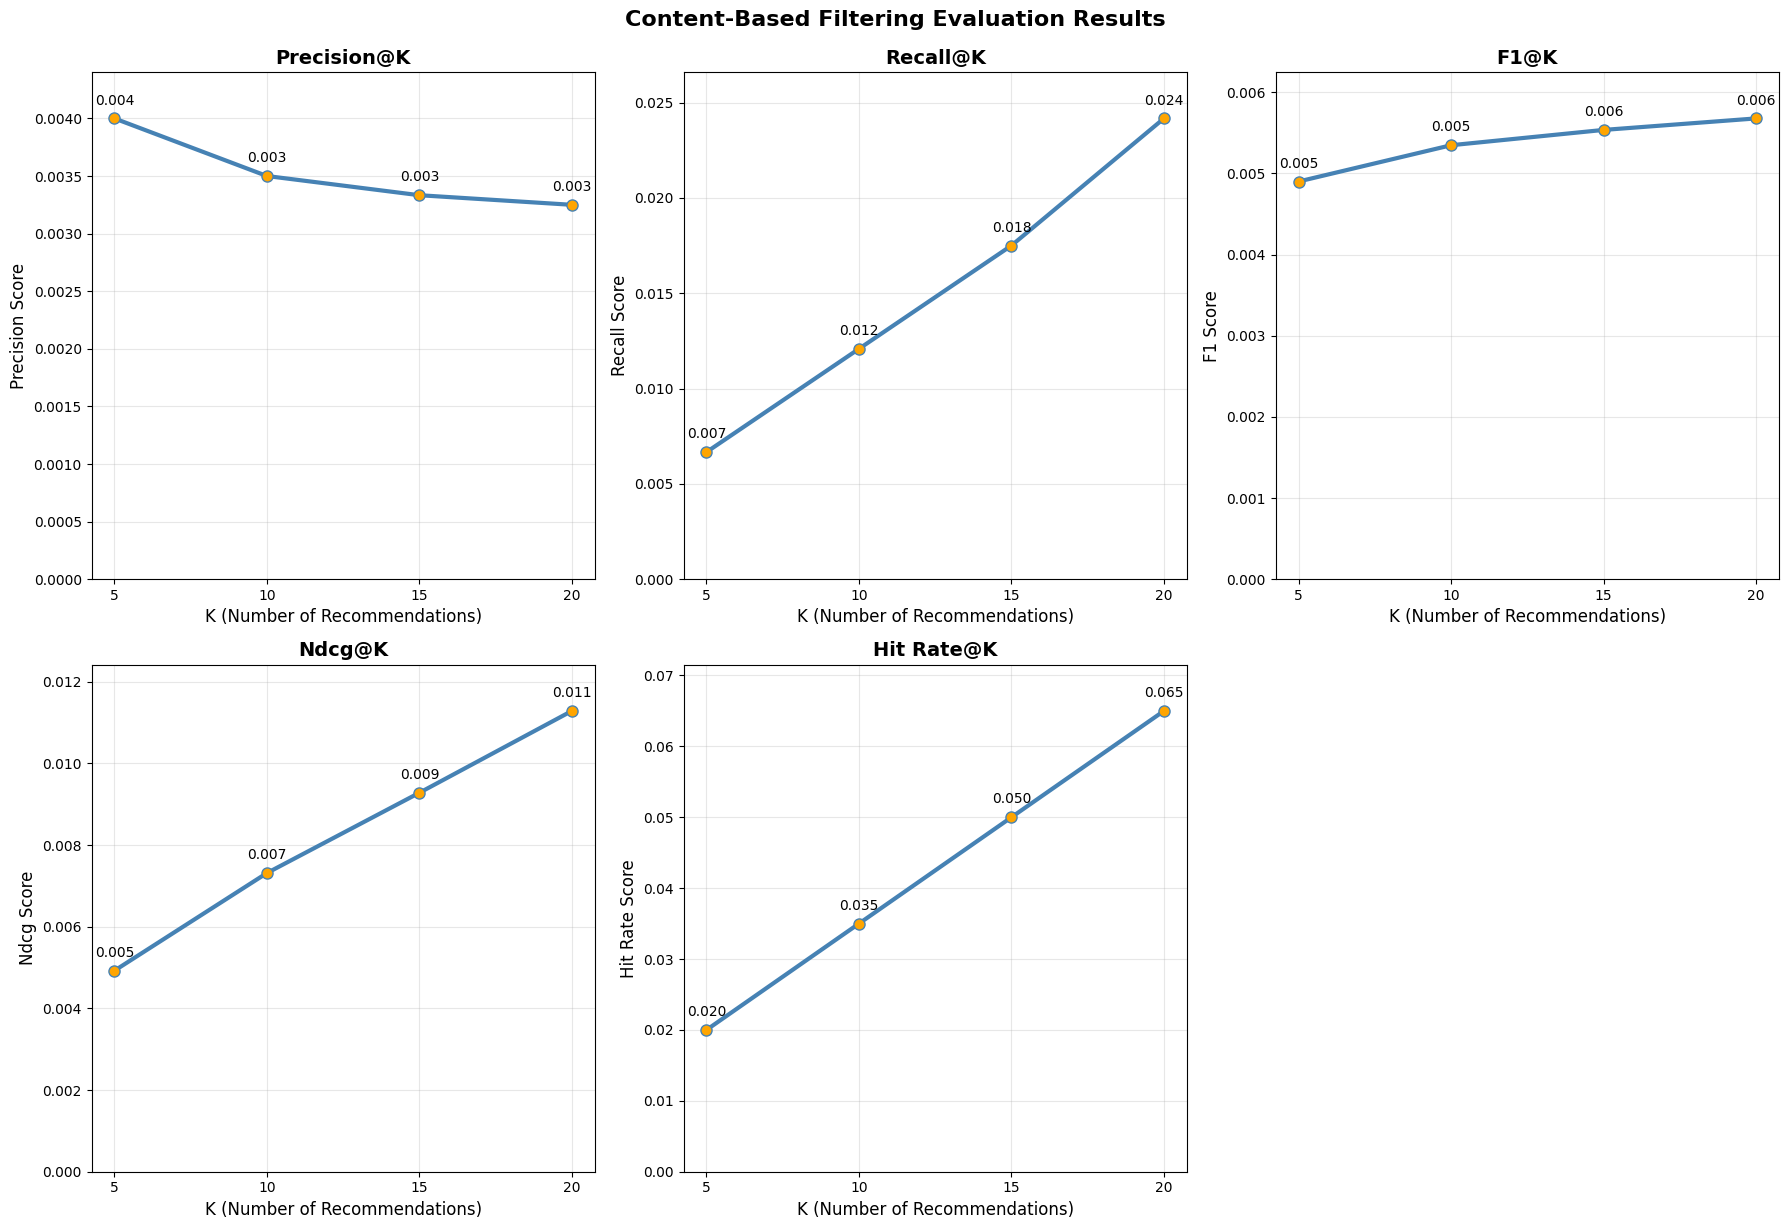

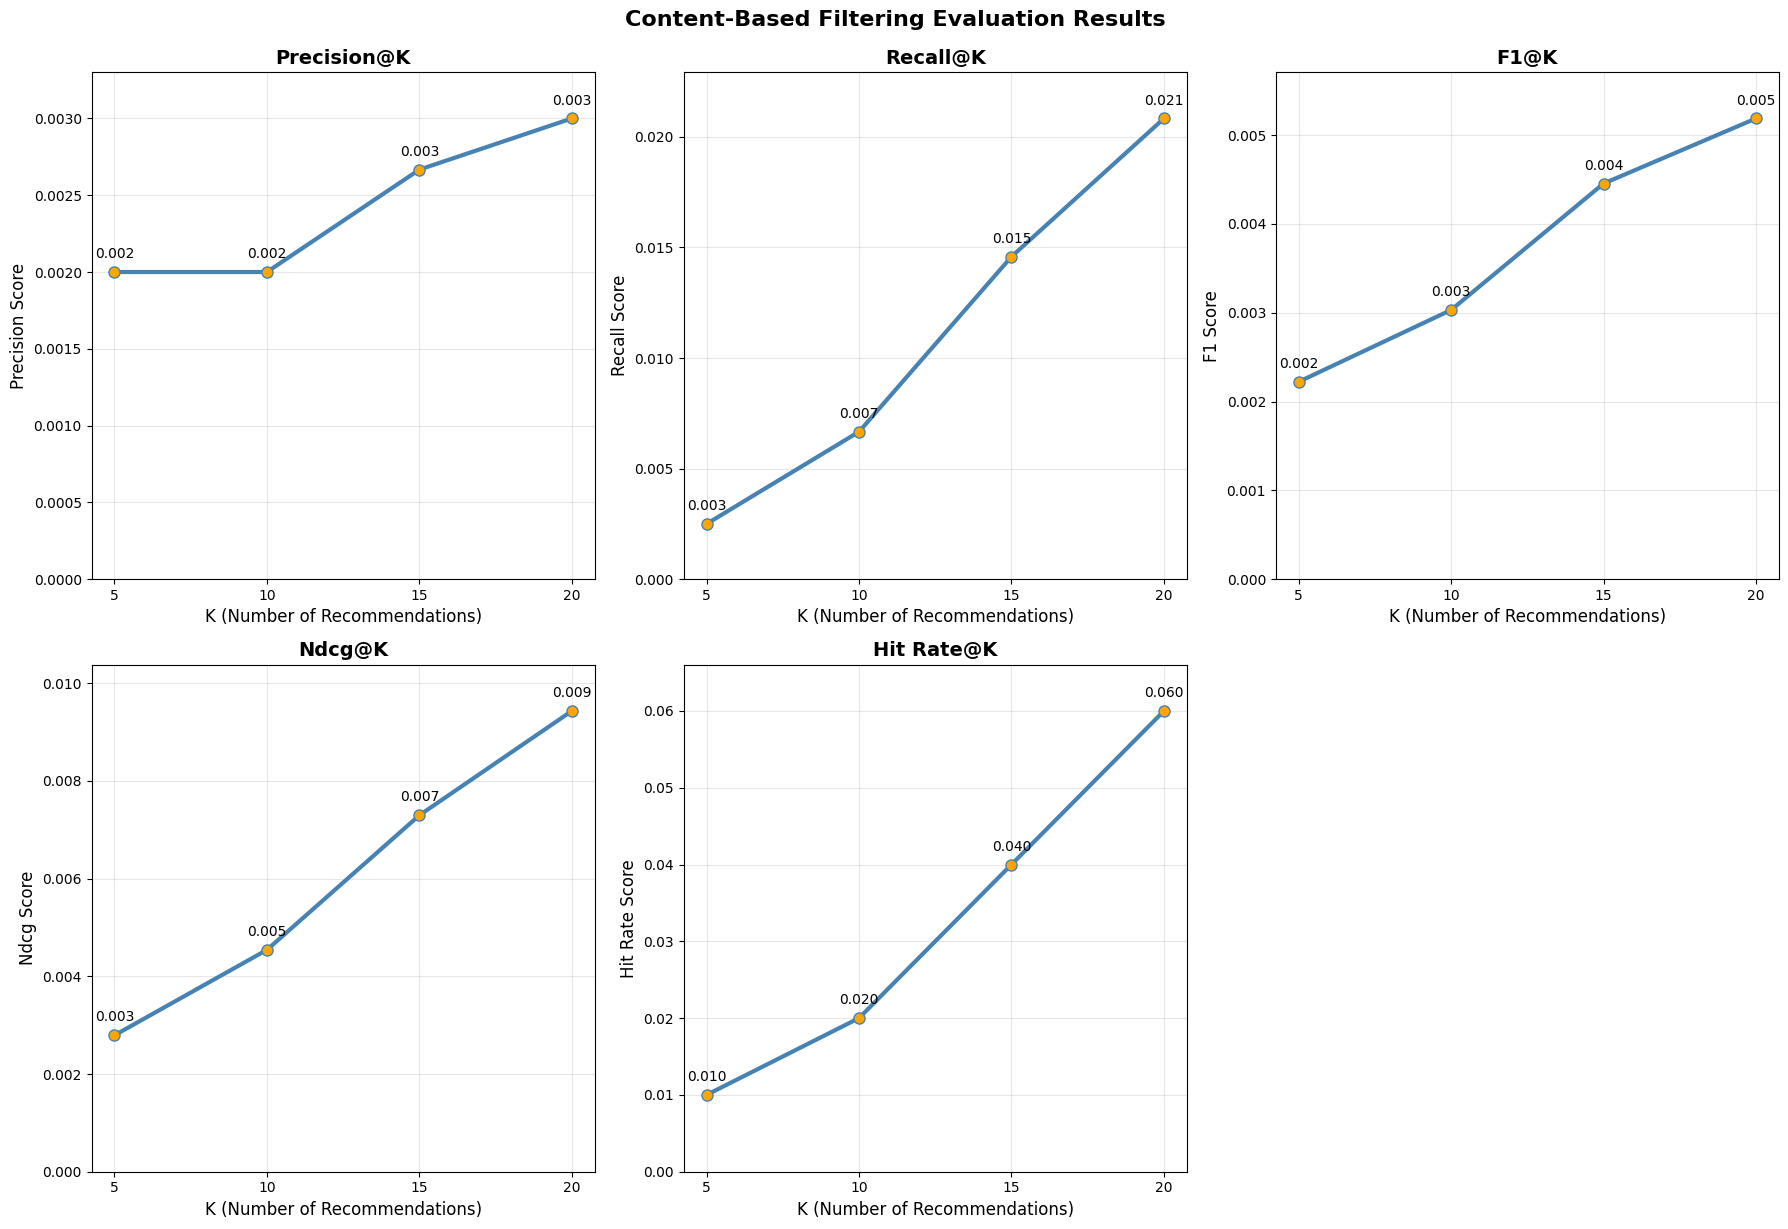

In [39]:
plot_evaluation_results(avg_results_cosine)
plot_evaluation_results(avg_results_knn)

# Improved Model Evaluation

Pada tahapan Improved Model Evaluation, dilakukan penyempurnaan sistem evaluasi untuk mendapatkan penilaian yang lebih akurat dan realistis terhadap performa model rekomendasi properti.

1. fungsi create_realistic_evaluation_data() untuk membuat data simulasi berdasarkan clustering properti
    - Mengelompokkan properti ke dalam 8 cluster berdasarkan fitur utama (rent, size_sqm, distance_to_station_km)
    - Mensimulasikan perilaku user yang cenderung tertarik pada cluster tertentu (1-3 cluster preference per user)
    - Membuat 200 simulasi user dengan pola preferensi yang realistis
2. fungsi create_weighted_feature_matrix() untuk memberikan bobot berbeda pada setiap jenis fitur:
    - Fitur numerik (harga, ukuran): bobot 2.0 (paling penting)
    - Fitur kategorikal (layout, lokasi): bobot 1.5 (cukup penting)
    - Fitur teks (deskripsi): bobot 1.0 (kurang penting)
3. fungsi evaluate_improved_system() untuk menghitung metrik evaluasi yang komprehensif, menambahkan metrik baru: Cluster Precision untuk mengukur seberapa baik sistem merekomendasikan properti dari cluster yang disukai user

**Hasil atau Temuan Utama**:
1. Top-K Recommendation Performance
- Weighted Cosine Similarity

| Top-K | Precision | Recall | F1-Score | NDCG   | Hit Rate | Cluster Precision |
|-------|-----------|--------|----------|--------|----------|-------------------|
| 5     | 0.0070    | 0.0040 | 0.0050   | 0.0075 | 0.0350   | 0.3370            |
| 10    | 0.0055    | 0.0081 | 0.0062   | 0.0076 | 0.0550   | 0.3240            |
| 15    | 0.0053    | 0.0126 | 0.0072   | 0.0095 | 0.0800   | 0.3277            |
| 20    | 0.0070    | 0.0239 | 0.0104   | 0.0140 | 0.1400   | 0.3210            |


- Weighted KNN (Euclidean Distance)

| Top-K | Precision | Recall | F1-Score | NDCG   | Hit Rate | Cluster Precision |
|-------|-----------|--------|----------|--------|----------|-------------------|
| 5     | 0.0080    | 0.0055 | 0.0063   | 0.0085 | 0.0400   | 0.3410            |
| 10    | 0.0085    | 0.0125 | 0.0097   | 0.0106 | 0.0750   | 0.3445            |
| 15    | 0.0087    | 0.0200 | 0.0115   | 0.0139 | 0.1150   | 0.3380            |
| 20    | 0.0080    | 0.0234 | 0.0115   | 0.0156 | 0.1450   | 0.3233            |



2. Coverage & Diversity

| Metric                         | Weighted Cosine Similarity | Weighted KNN (Euclidean) |
| ------------------------------ | -------------------------- | ------------------------ |
| **Catalog Coverage**           | 98.9%                      | 99.8%                    |
| **Average Layout Diversity**   | 20.0%                      | 20.0%                    |
| **Average Address Diversity**  | 83.1%                      | 82.6%                    |
| **Total Properties Evaluated** | 1000                       | 1000                     |

3. Hasil Rekomendasi Improved Model
- Cosine Similarity

| Rank | Property Name | Similarity Score | Address                | Rent (¥) | Year Built | Distance to Station (km) | Layout |
| ---- | ------------- | ---------------- | ---------------------- | -------- | ---------- | ------------------------ | ------ |
| 1    | Property\_261 | 0.993437         | Hiroshima, Peace Park  | 91,255   | 2010       | 2.5                      | 1DK    |
| 2    | Property\_21  | 0.992788         | Tokyo, Shinjuku        | 91,243   | 2012       | 2.9                      | 1DK    |
| 3    | Property\_16  | 0.967997         | Nagoya, Sakae          | 127,484  | 1999       | 2.2                      | 1DK    |
| 4    | Property\_750 | 0.921599         | Kyoto, Gion            | 134,304  | 2013       | 2.8                      | 1DK    |
| 5    | Property\_296 | 0.914336         | Sapporo, Susukino      | 106,865  | 2017       | 2.1                      | 1DK    |
| 6    | Property\_966 | 0.912809         | Nagoya, Sakae          | 156,628  | 2010       | 2.9                      | 1DK    |
| 7    | Property\_736 | 0.909901         | Sapporo, Susukino      | 114,086  | 2016       | 2.0                      | 1DK    |
| 8    | Property\_579 | 0.908776         | Hiroshima, Peace Park  | 111,245  | 2003       | 2.9                      | 1DK    |
| 9    | Property\_760 | 0.908308         | Kobe, Harborland       | 97,848   | 2010       | 2.1                      | 1DK    |
| 10   | Property\_524 | 0.901398         | Yokohama, Minato Mirai | 139,106  | 2012       | 2.2                      | 1DK    |

- KNN (euclidean distance)

| Rank | Property Name | Similarity Score | Address                | Rent (¥) | Year Built | Distance to Station (km) | Layout |
| ---- | ------------- | ---------------- | ---------------------- | -------- | ---------- | ------------------------ | ------ |
| 1    | Property\_21  | 0.620162         | Tokyo, Shinjuku        | 91,243   | 2012       | 2.9                      | 1DK    |
| 2    | Property\_261 | 0.589812         | Hiroshima, Peace Park  | 91,255   | 2010       | 2.5                      | 1DK    |
| 3    | Property\_16  | 0.451118         | Nagoya, Sakae          | 127,484  | 1999       | 2.2                      | 1DK    |
| 4    | Property\_750 | 0.401234         | Kyoto, Gion            | 134,304  | 2013       | 2.8                      | 1DK    |
| 5    | Property\_296 | 0.390609         | Sapporo, Susukino      | 106,865  | 2017       | 2.1                      | 1DK    |
| 6    | Property\_966 | 0.387538         | Nagoya, Sakae          | 156,628  | 2010       | 2.9                      | 1DK    |
| 7    | Property\_579 | 0.383953         | Hiroshima, Peace Park  | 111,245  | 2003       | 2.9                      | 1DK    |
| 8    | Property\_736 | 0.383838         | Sapporo, Susukino      | 114,086  | 2016       | 2.0                      | 1DK    |
| 9    | Property\_760 | 0.379472         | Kobe, Harborland       | 97,848   | 2010       | 2.1                      | 1DK    |
| 10   | Property\_524 | 0.373545         | Yokohama, Minato Mirai | 139,106  | 2012       | 2.2                      | 1DK    |


In [41]:
# 1. SIMULASI DATA YANG LEBIH REALISTIS
def create_realistic_evaluation_data(df, n_users=100, similarity_matrix=None):
    """
    Buat simulasi data yang lebih realistis berdasarkan clustering properti
    """
    # Clustering properti berdasarkan karakteristik serupa
    n_clusters = 8  # Sesuaikan dengan jumlah layout atau karakteristik
    
    # Buat cluster berdasarkan fitur utama (rent, size, location)
    cluster_features = df[['rent', 'size_sqm', 'distance_to_station_km']].values
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    df_temp = df.copy()
    df_temp['cluster'] = kmeans.fit_predict(cluster_features)
    
    evaluation_data = {}
    
    for user_id in range(n_users):
        # Simulasi user preference: user cenderung tertarik pada cluster tertentu
        preferred_clusters = random.sample(range(n_clusters), 
                                         random.randint(1, 3))  # 1-3 cluster preference
        
        # Simulasi behavior: user melihat properti dari cluster yang disukai
        seen_properties = []
        for cluster in preferred_clusters:
            cluster_properties = df_temp[df_temp['cluster'] == cluster].index.tolist()
            if cluster_properties:
                # Ambil beberapa properti dari cluster ini
                n_from_cluster = random.randint(2, min(6, len(cluster_properties)))
                seen_properties.extend(random.sample(cluster_properties, n_from_cluster))
        
        # Tambahkan beberapa properti random (noise/exploration)
        noise_properties = random.sample(range(len(df)), 
                                       random.randint(1, 3))
        seen_properties.extend(noise_properties)
        
        # Remove duplicates
        seen_properties = list(set(seen_properties))
        
        # Simulasi relevant properties: 
        # - Properti dari cluster yang sama lebih likely relevant
        # - 50-70% dari seen properties adalah relevant
        relevant_properties = []
        
        for prop_idx in seen_properties:
            prop_cluster = df_temp.loc[prop_idx, 'cluster']
            if prop_cluster in preferred_clusters:
                # 70% chance relevant jika dari preferred cluster
                if random.random() < 0.7:
                    relevant_properties.append(prop_idx)
            else:
                # 30% chance relevant jika bukan dari preferred cluster
                if random.random() < 0.3:
                    relevant_properties.append(prop_idx)
        
        # Pastikan minimal ada 1 relevant property
        if not relevant_properties and seen_properties:
            relevant_properties = [random.choice(seen_properties)]
        
        evaluation_data[user_id] = {
            'seen': seen_properties,
            'relevant': relevant_properties,
            'preferred_clusters': preferred_clusters
        }
    
    return evaluation_data, df_temp

# 2. FEATURE WEIGHTING YANG LEBIH BAIK
def create_weighted_feature_matrix(numeric_scaled_df, df_encoded, tfidf_df):
    """
    Buat feature matrix dengan bobot yang lebih optimal
    """
    # Normalisasi ulang dengan bobot berbeda
    numeric_weight = 2.0      # Fitur numerik lebih penting (harga, ukuran, dll)
    categorical_weight = 1.5  # Layout dan lokasi cukup penting  
    text_weight = 1.0         # Deskripsi kurang penting

    # numeric_weight = 1.2
    # categorical_weight = 1.0  
    # text_weight = 0.8 
    
    # Weighted features
    weighted_numeric = numeric_scaled_df.values * numeric_weight
    
    # Ambil kolom encoded yang sesuai
    encoded_cols = [col for col in df_encoded.columns 
                   if col.startswith(('layout_', 'address_'))]
    weighted_categorical = df_encoded[encoded_cols].values * categorical_weight
    
    weighted_text = tfidf_df.values * text_weight
    
    # Gabungkan
    weighted_feature_matrix = np.concatenate([
        weighted_numeric,
        weighted_categorical, 
        weighted_text
    ], axis=1)
    
    return weighted_feature_matrix

# 3. EVALUASI DENGAN IMPROVED METRICS
def evaluate_improved_system(similarity_data, df, evaluation_data, df_clustered,
                           k_values=[5, 10, 15, 20], method='cosine'):
    """
    Evaluasi sistem dengan simulasi data yang lebih realistis
    """
    results = {}
    for k in k_values:
        results[f'precision@{k}'] = []
        results[f'recall@{k}'] = []
        results[f'f1@{k}'] = []
        results[f'ndcg@{k}'] = []
        results[f'hit_rate@{k}'] = []
        results[f'cluster_precision@{k}'] = []  # Metrik tambahan
    
    successful_evaluations = 0
    
    for user_id, user_data in evaluation_data.items():
        seen_properties = user_data['seen']
        relevant_properties = user_data['relevant']
        preferred_clusters = user_data['preferred_clusters']
        
        if not seen_properties or not relevant_properties:
            continue
        
        # Pilih base property dari preferred cluster jika memungkinkan
        preferred_seen = [p for p in seen_properties 
                         if df_clustered.loc[p, 'cluster'] in preferred_clusters]
        base_property_idx = random.choice(preferred_seen if preferred_seen else seen_properties)
        
        try:
            for k in k_values:
                # Dapatkan rekomendasi
                if method == 'cosine':
                    similarity_matrix = similarity_data
                    sim_scores = list(enumerate(similarity_matrix[base_property_idx]))
                    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
                    sim_scores = sim_scores[1:k+1]
                    recommendations = [i[0] for i in sim_scores]
                elif method == 'knn':
                    distances, indices = similarity_data
                    recommendations = indices[base_property_idx][1:k+1]
                
                # Hitung metrik standar
                prec = precision_at_k(recommendations, relevant_properties, k)
                rec = recall_at_k(recommendations, relevant_properties, k)
                f1 = f1_at_k(recommendations, relevant_properties, k)
                ndcg = ndcg_at_k(recommendations, relevant_properties, k)
                hit = hit_rate_at_k(recommendations, relevant_properties, k)
                
                # Metrik tambahan: cluster precision
                recommended_clusters = [df_clustered.loc[idx, 'cluster'] 
                                      for idx in recommendations]
                cluster_matches = sum(1 for cluster in recommended_clusters 
                                    if cluster in preferred_clusters)
                cluster_prec = cluster_matches / k if k > 0 else 0
                
                # Simpan hasil
                results[f'precision@{k}'].append(prec)
                results[f'recall@{k}'].append(rec)
                results[f'f1@{k}'].append(f1)
                results[f'ndcg@{k}'].append(ndcg)
                results[f'hit_rate@{k}'].append(hit)
                results[f'cluster_precision@{k}'].append(cluster_prec)
            
            successful_evaluations += 1
            
        except Exception as e:
            continue
    
    # Hitung rata-rata
    avg_results = {}
    for metric, values in results.items():
        avg_results[metric] = np.mean(values) if values else 0
    
    print(f"Successful evaluations: {successful_evaluations}/{len(evaluation_data)}")
    return avg_results, results

# 5. PRINT RESULTS WITH CLUSTER METRICS
def print_improved_evaluation_summary(avg_results, method_name):
    """Print summary dengan metrik cluster"""
    print(f"\n{'='*60}")
    print(f"IMPROVED EVALUATION SUMMARY - {method_name.upper()}")
    print(f"{'='*60}")
    
    k_values = [5, 10, 15, 20]
    
    for k in k_values:
        print(f"\n--- TOP-{k} RECOMMENDATIONS ---")
        print(f"Precision@{k}:         {avg_results[f'precision@{k}']:.4f}")
        print(f"Recall@{k}:            {avg_results[f'recall@{k}']:.4f}")
        print(f"F1-Score@{k}:          {avg_results[f'f1@{k}']:.4f}")
        print(f"NDCG@{k}:              {avg_results[f'ndcg@{k}']:.4f}")
        print(f"Hit Rate@{k}:          {avg_results[f'hit_rate@{k}']:.4f}")
        print(f"Cluster Precision@{k}: {avg_results[f'cluster_precision@{k}']:.4f}")

In [42]:
# Step 1: Buat weighted feature matrix
weighted_feature_matrix = create_weighted_feature_matrix(
    numeric_scaled_df, df_encoded, tfidf_df
)

# Cosine similarity dengan weighted features
weighted_similarity_matrix = cosine_similarity(weighted_feature_matrix)

# KNN dengan weighted features  
weighted_knn_model = NearestNeighbors(metric='euclidean', n_neighbors=21)
weighted_knn_model.fit(weighted_feature_matrix)
weighted_distances, weighted_indices = weighted_knn_model.kneighbors(weighted_feature_matrix)

# Step 3: Buat realistic evaluation data
realistic_evaluation_data, df_clustered = create_realistic_evaluation_data(
    df, n_users=200, similarity_matrix=weighted_similarity_matrix
)

# Step 4: Evaluasi dengan improved system
print("Evaluating Improved Cosine Similarity...")
improved_results_cosine, _ = evaluate_improved_system(
    weighted_similarity_matrix, df, realistic_evaluation_data, df_clustered, method='cosine'
)

print("Evaluating Improved KNN...")
improved_results_knn, _ = evaluate_improved_system(
    (weighted_distances, weighted_indices), df, realistic_evaluation_data, df_clustered, method='knn'
)

# Step 5: Print hasil
print_improved_evaluation_summary(improved_results_cosine, "Cosine Similarity")
print_improved_evaluation_summary(improved_results_knn, "KNN (Euclidean Distance)")

Evaluating Improved Cosine Similarity...
Successful evaluations: 200/200
Evaluating Improved KNN...
Successful evaluations: 200/200

IMPROVED EVALUATION SUMMARY - COSINE SIMILARITY

--- TOP-5 RECOMMENDATIONS ---
Precision@5:         0.0070
Recall@5:            0.0040
F1-Score@5:          0.0050
NDCG@5:              0.0075
Hit Rate@5:          0.0350
Cluster Precision@5: 0.3370

--- TOP-10 RECOMMENDATIONS ---
Precision@10:         0.0055
Recall@10:            0.0081
F1-Score@10:          0.0062
NDCG@10:              0.0076
Hit Rate@10:          0.0550
Cluster Precision@10: 0.3240

--- TOP-15 RECOMMENDATIONS ---
Precision@15:         0.0053
Recall@15:            0.0126
F1-Score@15:          0.0072
NDCG@15:              0.0095
Hit Rate@15:          0.0800
Cluster Precision@15: 0.3277

--- TOP-20 RECOMMENDATIONS ---
Precision@20:         0.0070
Recall@20:            0.0239
F1-Score@20:          0.0104
NDCG@20:              0.0140
Hit Rate@20:          0.1400
Cluster Precision@20: 0.3210

I

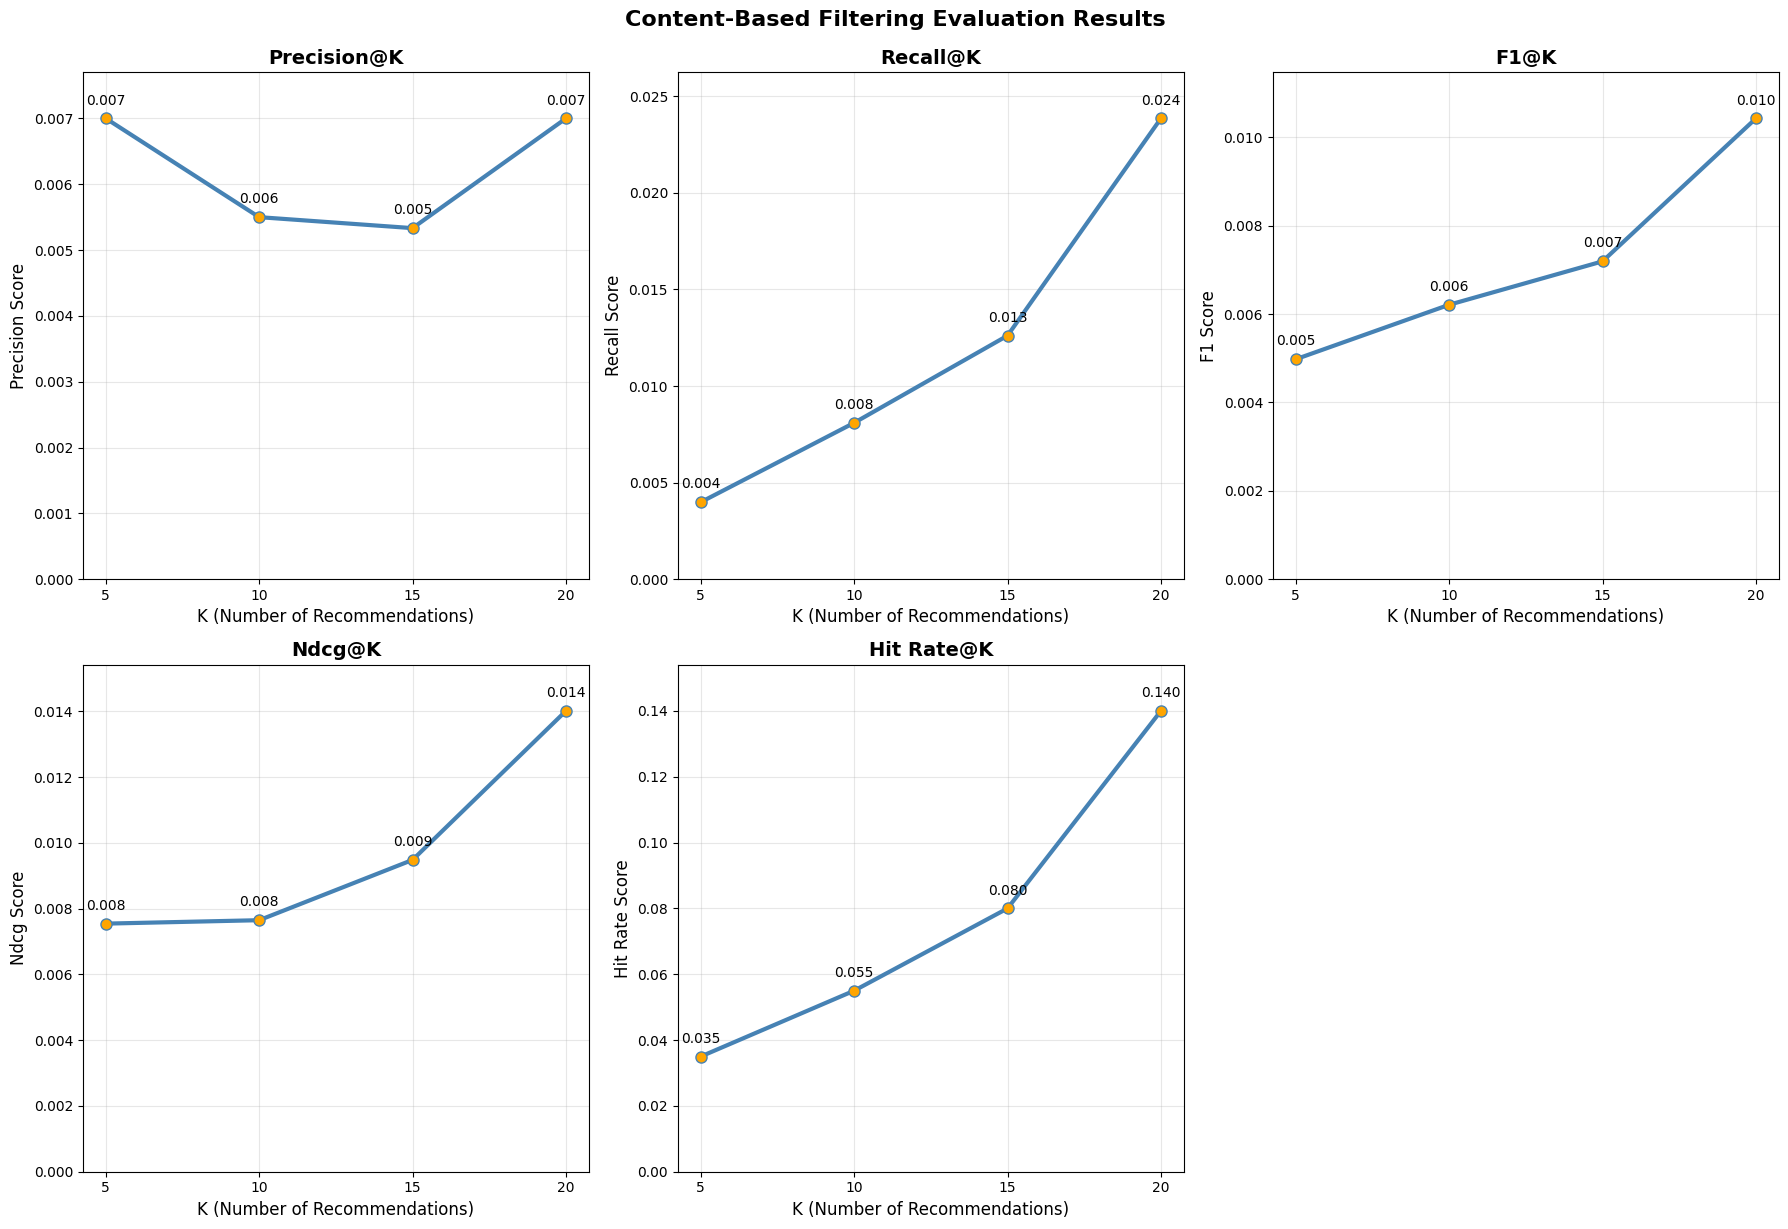

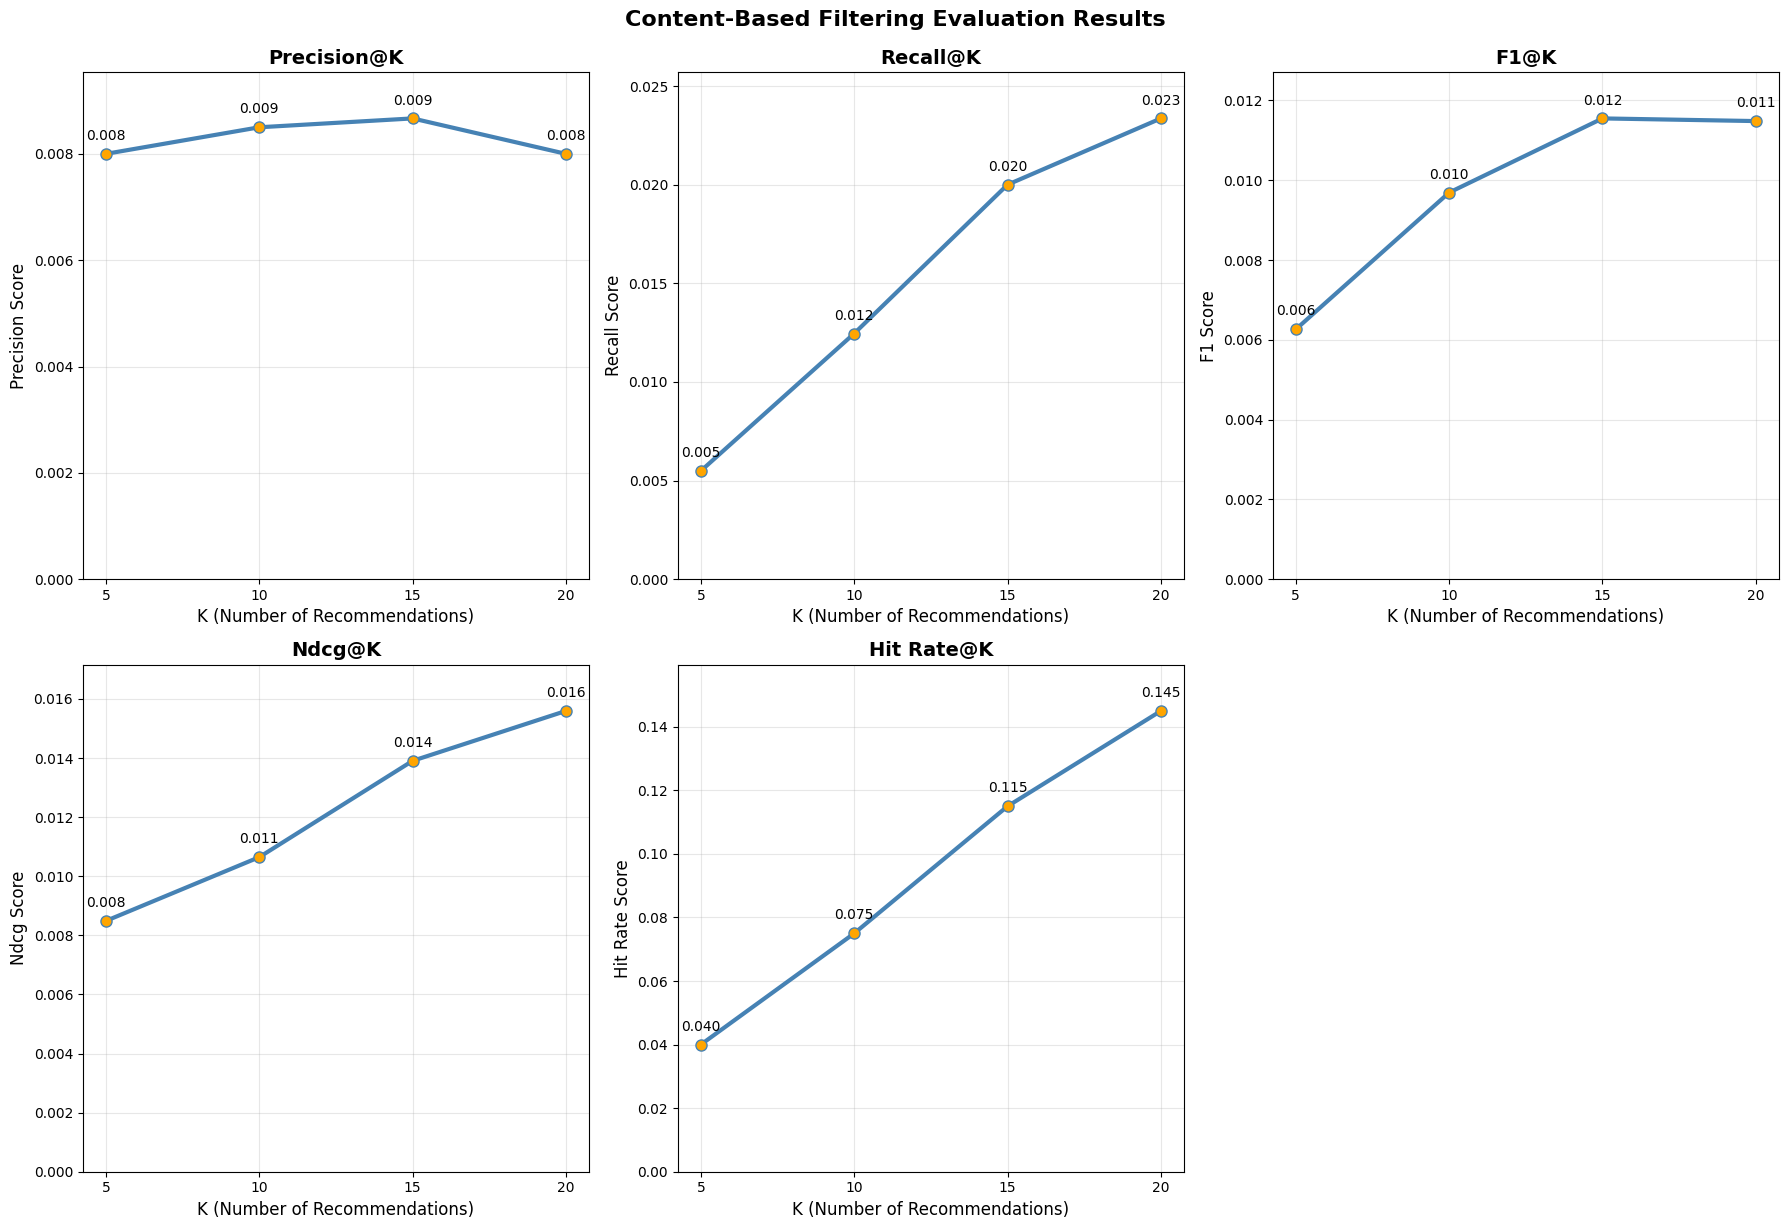

In [43]:
plot_evaluation_results(improved_results_cosine)
plot_evaluation_results(improved_results_knn)

In [44]:
# Daftar model yang ingin dievaluasi
models = {
    "Weighted Cosine Similarity": {
        "data": weighted_similarity_matrix,
        "method": "cosine"
    },
    "Weighted KNN (Euclidean)": {
        "data": (weighted_distances, weighted_indices),
        "method": "knn"
    }
}

# Loop untuk menghitung dan mencetak metrik evaluasi
for model_name, model_info in models.items():
    eval_metrics = calculate_diversity_metrics(model_info["data"], df, method=model_info["method"])
    
    print(f"\n📊 MODEL EVALUATION METRICS - {model_name.upper()}")
    print("=" * 50)
    print(f"Catalog Coverage:        {eval_metrics['catalog_coverage']:.1%}")
    print(f"Avg. Layout Diversity:   {eval_metrics['avg_layout_diversity']:.1%}")
    print(f"Avg. Address Diversity:  {eval_metrics['avg_address_diversity']:.1%}")
    print(f"Total Properties:        {eval_metrics['total_properties']}")


📊 MODEL EVALUATION METRICS - WEIGHTED COSINE SIMILARITY
Catalog Coverage:        98.9%
Avg. Layout Diversity:   20.0%
Avg. Address Diversity:  83.1%
Total Properties:        1000

📊 MODEL EVALUATION METRICS - WEIGHTED KNN (EUCLIDEAN)
Catalog Coverage:        99.4%
Avg. Layout Diversity:   20.0%
Avg. Address Diversity:  82.6%
Total Properties:        1000


In [45]:
# Cosine similarity with weighted features
recs_cosine = get_recommendations(
    property_name,
    weighted_similarity_matrix,
    df,
    top_n=10,
    method='cosine'
)

# Tampilkan hasil
if isinstance(recs_cosine, pd.DataFrame) and len(recs_cosine) > 0:
    print("🔍 Top Recommendations (Weighted Cosine):")
    print(recs_cosine[['property_name', 'similarity_score', 'address', 'rent', 'year_built', 'distance_to_station_km', 'layout']])

🔍 Top Recommendations (Weighted Cosine):
    property_name  similarity_score                 address    rent  \
260  Property_261          0.993437   Hiroshima, Peace Park   91255   
20    Property_21          0.992788         Tokyo, Shinjuku   91243   
15    Property_16          0.967997           Nagoya, Sakae  127484   
749  Property_750          0.921599             Kyoto, Gion  134304   
295  Property_296          0.914336       Sapporo, Susukino  106865   
965  Property_966          0.912809           Nagoya, Sakae  156628   
735  Property_736          0.909901       Sapporo, Susukino  114086   
578  Property_579          0.908776   Hiroshima, Peace Park  111245   
759  Property_760          0.908308        Kobe, Harborland   97848   
523  Property_524          0.901398  Yokohama, Minato Mirai  139106   

     year_built  distance_to_station_km layout  
260        2010                     2.5    1DK  
20         2012                     2.9    1DK  
15         1999               

In [46]:
# KNN with weighted features
recs_knn = get_recommendations(
    property_name,
    (weighted_distances, weighted_indices),
    df,
    top_n=10,
    method='knn'
)

# Tampilkan hasil
if isinstance(recs_knn, pd.DataFrame) and len(recs_knn) > 0:
    print("🔍 Top Recommendations (Weighted KNN):")
    print(recs_knn[['property_name', 'similarity_score', 'address', 'rent', 'year_built', 'distance_to_station_km', 'layout']])

🔍 Top Recommendations (Weighted KNN):
    property_name  similarity_score                 address    rent  \
20    Property_21          0.620162         Tokyo, Shinjuku   91243   
260  Property_261          0.589812   Hiroshima, Peace Park   91255   
15    Property_16          0.451118           Nagoya, Sakae  127484   
749  Property_750          0.401234             Kyoto, Gion  134304   
295  Property_296          0.390609       Sapporo, Susukino  106865   
965  Property_966          0.387538           Nagoya, Sakae  156628   
578  Property_579          0.383953   Hiroshima, Peace Park  111245   
735  Property_736          0.383838       Sapporo, Susukino  114086   
759  Property_760          0.379472        Kobe, Harborland   97848   
523  Property_524          0.373545  Yokohama, Minato Mirai  139106   

     year_built  distance_to_station_km layout  
20         2012                     2.9    1DK  
260        2010                     2.5    1DK  
15         1999                  